# Content
1. [Setup and Imports](#Setup-and-Imports)
2. [Configuration](#Configuration)
3. [Reproducibility](#Reproducibility)
4. [Data Collection Process](#Data-Collection-Process)
5. [Exploring the Dataset](#Exploring-the-Dataset)
6. [Cleaning the Data](#Cleaning-the-Data)
7. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
8. [Probability Analysis and Hypotheses](#Probability-Analysis-and-Hypotheses)
9. [Data Preprocessing](#Data-Preprocessing)
10. [Machine Learning](#Machine-Learning)

# Setup and Imports

In [1]:
# File Handling and Data Manipulation
import glob  # For file handling and pathname matching
import numpy as np
import pandas as pd  # Data manipulation and analysis

# Hypothesis testing
from scipy.stats import ttest_ind

# Visualization
import seaborn as sns  # Statistical data visualization
import matplotlib.pyplot as plt

# Web Scraping and HTML Parsing
import requests  # For making HTTP requests
from bs4 import BeautifulSoup  # BeautifulSoup for HTML parsing

# Machine Learning Libraries
import torch  # PyTorch for deep learning models
import torch.nn as nn  # Neural network modules in PyTorch
import torch.optim as optim  # Optimizers in PyTorch
from torch.optim import lr_scheduler  # Learning rate scheduling in PyTorch
from sklearn.pipeline import Pipeline  # Scikit-learn pipeline for chaining preprocessing steps
from sklearn.decomposition import PCA  # Principal component analysis from Scikit-learn
from sklearn.compose import ColumnTransformer  # Data transformation for specific columns
from sklearn.ensemble import RandomForestRegressor  # Random Forest Regressor model
from sklearn.tree import DecisionTreeRegressor  # Decision Tree Regressor model
from sklearn.linear_model import LinearRegression  # Linear Regression model
from sklearn.model_selection import train_test_split  # Splitting data into train and test sets
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Data preprocessing tools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Evaluation metrics
from scipy.stats import skew  # Measure skewness of data distribution

# Other
import warnings  # Suppressing unnecessary warnings
import optuna  # Optimization
import pickle  # Saving and loading

In [2]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Set default Seaborn settings
sns.set(
    style='ticks',
    rc={
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.bottom": False,
        "axes.spines.left": False,
        "xtick.bottom": False,
        "ytick.left": False,
        "font.size": 10
    }
)

# Set default font sizes for x and y labels and title
plt.rcParams.update({
    'axes.labelsize': 'medium',  # Default font size for labels
    'axes.titlesize': 'medium',  # Default font size for title
})

# Set default grid color to a lighter shade of gray
plt.rcParams['grid.color'] = (0.9, 0.9, 0.9)

# Display color palette
sns.set_palette(sns.color_palette(['#3884FD', '#F9A159', '#273A68', '#F8D341', '#D5454F']))

# Configuration
This section will be used to define constant variables.

In [3]:
class Config:
    # Seed value used to ensure reproducibility in random processes.
    SEED = 42

    # Custom headers for the HTTP request to mimic a common browser user agent.
    HEADERS = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
        "(KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36"
    }

    # Initial set of column names for creating a DataFrame.
    COLUMNS = [
        "price", "make", "model", "mileage", "seats", "bodyColor", "modelYear",
        "doors", "gearBox", "emissionPerKm", "gears", "fuelType", "performance",
        "cubicCapacity", "categories", "interiorColor", "batteryCapacityKwh",
        "energyEfficiencyClass", "fuelConsumptionOuter", "fuelConsumptionInner",
        "fuelConsumptionCombined", "electricConsumption", "fuelConsumptionWltpCombined",
        "undamaged", "firstRegistrationDate", "url"
    ]

    # Base URL
    BASE_URL = "https://api.hey.car/search?id="

    # Asymmetric features to which logarithmic transformation will then be applied
    ASYMMETRIC_FEATURES = []

    # Custom color palette
    COLOR_PALETTE = ['#3884FD', '#F9A159', '#273A68', '#F8D341', '#D5454F']

    # Set current year
    YEAR = 2024
    
config = Config()

# Reproducibility

In [4]:
# Set random seed for numpy
np.random.seed = config.SEED

# Set random seed for Pytorch
torch.manual_seed(config.SEED)

# Data Collection Process
When deciding on the actual data to use when starting this project, we first decided on the country from which we wanted to collect postings. The main criteria were that there were enough advertisements and that price movements were not too volatile due to inflation. In this case, **Germany** was our first choice. We reviewed the most popular online portals offering second-hand vehicle listings. Although most websites state that there are 100s of thousands of advertisements, it was possible to reach a maximum of 1000 or fewer advertisements through the search component. In this case, as a result of our elimination, we decided on **"[Hey Car](https://hey.car/)"** because it allowed us to access almost all listings. The first step in data mining from this site was to collect the URLs of the vehicles by going through the search pages of the brand, and the second step was to obtain more detailed data by entering the vehicles' own webpage on each search page. The first step went smoothly, but in the second step we could not obtain vehicle data because the site was dynamically loading the web page. There was no data about the car in the source code received as a result of the GET request. BeautifulSoup would be insufficient for this problem, Selenium could be used. However, we came up with the idea of trying a different solution. We examined the requests sent by the site from the Network tab in the developer tool's section of the browser. From here we found the section where it pulls vehicle data. That is, directly from their servers via the RESTFull API. In this way, the second part of the data collection process took place much faster than it would have otherwise.

In [5]:
# Method to send request and collect data of specified car
def get_car_details(url):
    """
    Fetches details of a specified car by sending a GET request to the provided URL.

    Parameters:
    url (str): The URL to send the GET request for car details.

    Returns:
    dict: A dictionary containing various details of the specified car if the request was successful.
          If the request fails, an empty dictionary is returned.
    """
    # Make a GET request to the URL with custom headers
    response = requests.get(url, headers=config.HEADERS)

    # Create new car data
    car_data = {}

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Extract data from the JSON response
        json_data = response.json()

        content = json_data.get("content", [{}])[0]  # Handling empty content list
        car_data["price"] = content.get("price")
        car_data["make"] = content["model"].get("make") if "model" in content else None
        car_data["model"] = content["model"].get("id") if "model" in content else None
        car_data["mileage"] = content.get("mileage")
        car_data["seats"] = content.get("seats")
        car_data["bodyColor"] = content.get("bodyColor")
        car_data["modelYear"] = content.get("modelYear")
        car_data["doors"] = content.get("doors")
        car_data["gearBox"] = content.get("gearBox")
        car_data["emissionPerKm"] = content.get("emissionPerKm")
        car_data["gears"] = content.get("gears")
        car_data["fuelType"] = content.get("fuelType")
        car_data["performance"] = content.get("performance")
        car_data["cubicCapacity"] = content.get("cubicCapacity")
        car_data["categories"] = content.get("categories", [None])[0]
        car_data["interiorColor"] = content.get("interiorColor")
        car_data["batteryCapacityKwh"] = content.get("batteryCapacityKwh")
        car_data["energyEfficiencyClass"] = content.get("energyEfficiencyClass")
        car_data["fuelConsumptionOuter"] = content.get("fuelConsumptionOuter")
        car_data["fuelConsumptionInner"] = content.get("fuelConsumptionInner")
        car_data["fuelConsumptionCombined"] = content.get("fuelConsumptionCombined")
        car_data["electricConsumption"] = content.get("electricConsumption")
        car_data["fuelConsumptionWltpCombined"] = content.get("fuelConsumptionWltpCombined")
        car_data["undamaged"] = content.get("undamaged")
        car_data["firstRegistrationDate"] = content.get("firstRegistrationDate")
        car_data["url"] = url
    else:
        # Print an error message if the request failed
        print("Failed to fetch data. Status code:", response.status_code)

    return car_data

In [6]:
# Main method to collect data for specified make
def scrape_car_data(make):
    """
    Scrapes data for a specified car make from 'https://hey.car/' by iterating through multiple pages
    and collects information about used cars of the specified make.

    Parameters:
    make (str): The car make for which data will be collected.

    Returns:
    None
    """
    data = []
    total_cars = 3200  # Total number of cars to collect
    cars_collected = 0  # Counter for cars collected
    
    page_num = 0
    
    # Loop until the desired number of cars is collected
    while cars_collected < total_cars:
        # Construct the URL for the specific car make and page number
        url = f"https://hey.car/gebrauchtwagen?make={make}&model={make}_all&trim={make}_all_all&page={page_num}"
        response = requests.get(url, headers=config.HEADERS)
    
        # Check if the GET request was successful (status code 200)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            car_elements = soup.find_all("a", class_="sc-1jary5l-0 kniega behe4d-1 fdXYci")
    
            # Extract car URLs and scrape car details for each car element
            for element in car_elements:
                car_url = element.get("href")
    
                # Edit car URL to make it ready for further processing
                car_url_edited = car_url.split("/")[2].split("?")[0]
    
                # Use the get_car_details function to retrieve car data
                car_data = get_car_details(config.BASE_URL + car_url_edited)
                data.append(car_data)
                cars_collected += 1
    
            # Print current progress - scraped page number and total cars collected
            print(f"Scraped page {page_num} - Total cars collected: {cars_collected}")
    
            # Create a DataFrame from the collected data and save it to a CSV file
            df = pd.DataFrame(data, columns=config.COLUMNS)
            df.to_csv(f"{make}_partial.csv", index=False)
    
            # Check if the desired number of cars is collected, and exit the loop if so
            if cars_collected >= total_cars:
                break
    
        page_num += 1  # Move to the next page
    
    # Save the final DataFrame to a CSV file named 'make.csv'
    df.to_csv(f"{make}.csv", index=False)
    print(f"Data saved to '{make}.csv'")

# Exploring the Dataset

In [7]:
# Find all CSV files in data directory
folder_path = 'data/'
csv_files = glob.glob(folder_path + '*.csv')

# List to hold the dataframes
dataframes = []

# Read each CSV file and append its contents to the list
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Concatenate all dataframes into a single dataframe
df = pd.concat(dataframes, ignore_index=True)

In [8]:
# Show first five observation of the dataset
df.head()

,price,make,model,mileage,seats,bodyColor,modelYear,doors,gearBox,emissionPerKm,...,batteryCapacityKwh,energyEfficiencyClass,fuelConsumptionOuter,fuelConsumptionInner,fuelConsumptionCombined,electricConsumption,fuelConsumptionWltpCombined,undamaged,firstRegistrationDate,url
0,22480,audi,a1,6971,5.0,white,2023.0,5.0,manual_gear,108.0,...,NaN,B,4.1,5.9,4.7,NaN,5.7,True,2023-02-15,https://api.hey.car/search?id=c47fa0eb-994f-44...
1,28450,audi,a1,6200,5.0,grey,2023.0,5.0,automatic_gear,109.0,...,NaN,B,4.4,5.4,4.8,NaN,5.9,True,2022-11-01,https://api.hey.car/search?id=027e9c9d-635b-43...
2,23750,audi,a1,1473,5.0,othercolor,2024.0,4.0,manual_gear,NaN,...,NaN,none,NaN,NaN,NaN,NaN,NaN,True,2023-11-01,https://api.hey.car/search?id=7a411980-4342-4a...
3,28500,audi,a3,6600,5.0,black,2023.0,4.0,manual_gear,109.0,...,NaN,A+,4.0,6.1,4.8,NaN,NaN,False,2023-03-15,https://api.hey.car/search?id=fb5aab8a-62f6-4c...
4,19380,audi,q2,18492,5.0,grey,NaN,5.0,manual_gear,118.0,...,NaN,B,4.5,6.4,5.2,NaN,NaN,True,2019-10-01,https://api.hey.car/search?id=44262ee5-73a7-4e...


We can already see that we have a lot of null values to deal with.

## Metadata

| **Column Name**           | **Description**                                              |
|--------------------------|----------------------------------------------------------|
| **price**                    | Price of the vehicle in Euro (€)                         |
| **make**                     | Manufacturer or brand of the vehicle                     |
| **model**                    | Model name or designation of the vehicle                 |
| **mileage**                  | Distance traveled by the vehicle (kilometers)            |
| **seats**                    | Number of seats in the vehicle                           |
| **bodyColor**                | Color of the vehicle's body                              |
| **modelYear**                | Year the vehicle model was manufactured                  |
| **doors**                    | Number of doors in the vehicle                           |
| **gearBox**                  | Type of gearbox/transmission                             |
| **emissionPerKm**            | Emission rate per kilometer (g)                             |
| **gears**                    | Number of gears in the vehicle transmission              |
| **fuelType**                 | Type of fuel used by the vehicle                         |
| **performance**              | Vehicle performance characteristics in kW                |
| **cubicCapacity**            | Engine capacity in cubic centimeters (cc)                |
| **categories**               | Categorization details of the vehicle                    |
| **interiorColor**            | Color of the vehicle's interior                          |
| **batteryCapacityKwh**       | Battery capacity in kilowatt-hours (kWh)                 |
| **energyEfficiencyClass**    | Energy efficiency class rating of the vehicle            |
| **fuelConsumptionOuter**     | Fuel consumption rate in outer urban areas               |
| **fuelConsumptionInner**     | Fuel consumption rate in inner urban areas               |
| **fuelConsumptionCombined**  | Combined fuel consumption rate                           |
| **electricConsumption**      | Electric consumption rate                                |
| **fuelConsumptionWltpCombined** | WLTP (Worldwide Harmonized Light Vehicles Test Procedure) combined fuel consumption rate |
| **undamaged**                | Indication of whether the vehicle is undamaged           |
| **firstRegistrationDate**    | Date of the vehicle's first registration                 |
| **url**                      | URL of API related to the vehicle                        |


## Dataset Overview

In [9]:
# Printing the number of features in the raw dataset
print(f"Number of features in raw dataset: {df.shape[1]}")

Number of features in raw dataset: 26


In [10]:
# Printing the number of observations (rows) in the raw dataset
print(f"Number of observations in the raw dataset: {df.shape[0]}")

Number of observations in the raw dataset: 32160


In [11]:
# Get details about raw dataset (Null counts, data types...)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32160 entries, 0 to 32159
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price                        32160 non-null  int64  
 1   make                         32160 non-null  object 
 2   model                        32160 non-null  object 
 3   mileage                      32160 non-null  int64  
 4   seats                        31675 non-null  float64
 5   bodyColor                    32160 non-null  object 
 6   modelYear                    9103 non-null   float64
 7   doors                        31893 non-null  float64
 8   gearBox                      32160 non-null  object 
 9   emissionPerKm                29862 non-null  float64
 10  gears                        17965 non-null  float64
 11  fuelType                     32160 non-null  object 
 12  performance                  32155 non-null  float64
 13  cubicCapacity   


- **Total Observations:** 32,160
- **Total Features:** 26

### Features Information

The dataset includes a diverse range of data types and exhibits missing values in several columns:

1. **Numerical Features:**
   - Integers: `price`, `mileage`, `cubicCapacity`
   - Floats: `seats`, `modelYear`, `doors`, `emissionPerKm`, `gears`, `performance`, `batteryCapacityKwh`, `fuelConsumptionOuter`, `fuelConsumptionInner`, `fuelConsumptionCombined`, `electricConsumption`, `fuelConsumptionWltpCombined`

2. **Categorical Features:**
   - `make`, `model`, `bodyColor`, `gearBox`, `fuelType`, `categories`, `interiorColor`, `energyEfficiencyClass`, `undamaged`, `firstRegistrationDate`, `url`

### Missing Values

- Columns like `modelYear`, `gears`, `batteryCapacityKwh`, `electricConsumption`, among others, exhibit a notable count of missing values.
- `firstRegistrationDate` and other columns also have missing data, but to a lesser extent.

### Observations
- The dataset seemingly contains information about vehicles, encompassing details regarding specifications, features, and performance metrics.
- Variations exist in data completeness across different features, indicating the necessity for data preprocessing steps such as handling missing values before analysis or modeling.

### Data Types

- The dataset comprises a mix of numerical (integers, floats) and categorical (objects) data types.

### Memory Usage

- The dataset consumes approximately 6.4+ MB of memory.

### Potential Steps

1. **Data Cleaning:**
   - Address missing values through imputation or removal based on the nature of the columns.
   - Convert appropriate columns to their correct data types (e.g., dates to datetime format).

2. **Exploratory Data Analysis (EDA):**
   - Understand distributions, correlations, and insights within the dataset.
   - Visualize relationships between different features.

3. **Preprocessing:**
   - Encode categorical variables if necessary for machine learning models.
   - Scale numerical features if needed for certain algorithms.

4. **Model Building or Analysis:**
   - Depending on the objective, build predictive models or perform analysis using the preprocessed dataset.

5. **Validation and Iteration:**
   - Validate models or analysiial steps required for further analysis or modeling.


In [12]:
# Generate descriptive statistics summarizing the numerical columns in the raw data
df.describe()

,price,mileage,seats,modelYear,doors,emissionPerKm,gears,performance,cubicCapacity,batteryCapacityKwh,fuelConsumptionOuter,fuelConsumptionInner,fuelConsumptionCombined,electricConsumption,fuelConsumptionWltpCombined
count,32160.000000,32160.000000,31675.000000,9103.000000,31893.000000,29862.000000,17965.000000,32155.000000,32160.000000,6037.000000,22798.000000,22798.000000,29609.000000,1930.000000,17132.000000
mean,32410.807929,25284.559764,4.931744,2021.277271,4.698210,112.758656,6.327247,120.219530,1411.525062,11.924184,4.631852,6.232451,6.514963,15.278250,6.766802
std,20391.220093,31155.139270,0.710746,5.039638,0.684124,62.140666,1.711701,62.082946,832.178740,17.861961,3.558810,4.091366,7.467791,18.415865,9.537873
min,2500.000000,0.000000,1.000000,1986.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19890.000000,3500.000000,5.000000,2020.000000,5.000000,104.000000,6.000000,81.000000,999.000000,0.400000,4.000000,5.400000,4.700000,14.400000,5.200000
50%,26800.000000,15072.000000,5.000000,2022.000000,5.000000,122.000000,6.000000,110.000000,1398.000000,0.900000,4.600000,6.300000,5.400000,16.100000,6.000000
75%,37990.000000,33762.000000,5.000000,2023.000000,5.000000,142.000000,8.000000,140.000000,1969.000000,13.500000,5.200000,7.200000,6.400000,17.700000,7.100000
max,432300.000000,526264.000000,58.000000,2323.000000,54.000000,1400.000000,10.000000,620.000000,77000.000000,100.000000,129.000000,161.000000,286.700000,286.700000,628.000000


These summary statistics show clearly that in our raw data that there are many problems that need to be solved. For example, the maximum number of seats and doors. I think it is not possible for a car to have 54 doors. Similar findings can be said for other numerical columns. That's why we need to **analyze the outliers** and get rid of them. In addition, since the units of numerical values are different, they are not suitable for machine learning, we need to **standardize** these values.

# Cleaning the Data

Data cleaning is a critical step in preparing a dataset for analysis or modeling. It involves various procedures to ensure data quality, accuracy, and consistency. The process typically follows a sequential order to address different types of issues within the dataset.

1. **Handling Duplicates:** The initial step involves identifying and removing duplicate entries within the dataset. Duplicate records can skew analysis and modeling results, so eliminating them ensures the dataset's uniqueness.

2. **Dealing with Missing Values:** Next, addressing missing values is crucial. This step involves imputing or removing missing data points. Missing values can impact the integrity of analyses, and handling them appropriately ensures the dataset's completeness.

3. **Managing Outliers:** Outliers, data points significantly different from others, can adversely affect statistical analyses and model performance. Managing outliers involves detecting and appropriately treating these extreme values.

4. **Resolving Inconsistencies:** Lastly, inconsistencies in the dataset need to be addressed. Inconsistencies might arise due to discrepancies or errors in data collection or entry. Resolving these issues ensures data accuracy and reliability.

Following this sequence helps systematically clean the dataset, ensuring that it is free from duplicates, missing values, outliers, and inconsistencies. A clean dataset is fundamental for accurate and reliable analyses and models in data science.


## Dealing with Duplicates

By identifying and managing duplicate values within our raw dataset, we leverage the unique URLs associated with each observation as a distinctive identifier to detect and address any instances of data duplication.

In [13]:
# Counting the number of duplicate rows in the dataset
number_of_duplicates = df.duplicated().sum()

# Displaying the count of duplicate rows
print(f"Number of duplicate values in raw data: {number_of_duplicates}")

Number of duplicate values in raw data: 9935


In [14]:
# Drop duplicates
df.drop_duplicates(subset='url', inplace=True)

# Reset the index
df.reset_index(drop=True, inplace=True)

In [15]:
# New number of observations after dropping duplicates
print(f"After dropping duplicates number of remaining observations: {df.shape[0]}")

After dropping duplicates number of remaining observations: 22225


## Handling Missing Values

In [16]:
# Total null count in remaninig observations
print(f"There are a total of {df.isna().sum().sum()} null values in the raw data set.")

There are a total of 98189 null values in the raw data set.


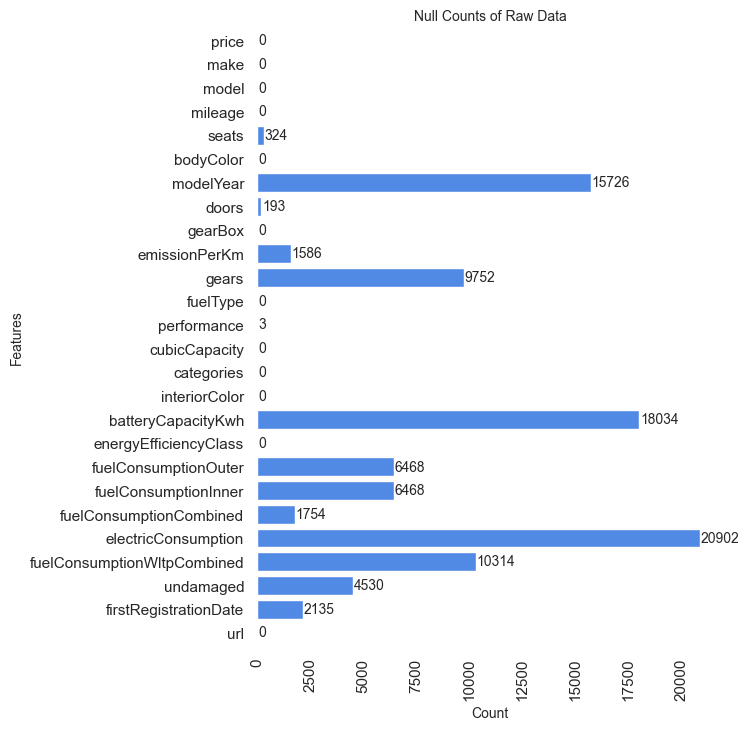

In [17]:
def plot_nulls(df, title):
    """
    Plots a bar chart showing the count of null values for each feature in the provided DataFrame.

    Parameters:
    - df : pandas DataFrame
        The DataFrame containing the dataset.
    - title : str
        Title for the plot.

    Returns:
    - None
    """
    # Calculate the count of null values for each feature
    null_counts = df.isna().sum()
    
    # Set the size of the plot figure (increase vertical length)
    plt.figure(figsize=(6, 8))
    
    # Create a bar plot for null counts
    null_plot = sns.barplot(x=null_counts.values, y=null_counts.index)

    
    # Set plot labels and title
    null_plot.set(title=title,
                  xlabel='Count', ylabel='Features')
    
    # Annotate the bars with counts
    for patch in null_plot.patches:
        x = patch.get_width()
        y = patch.get_y() + patch.get_height() / 2
        null_plot.annotate(f'{x:.0f}', (x + 25, y), ha='left', va='center')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)
    
    # Show the plot
    plt.show()

plot_nulls(df, 'Null Counts of Raw Data')

To address missing values, we will prioritize fixing the 'modelYear' column initially, given its significance for subsequent imputations. After rectifying 'modelYear', we will focus on features with fewer missing entries. We aim to impute these missing values by leveraging consistent characteristics within the make, model, and modelYear of a car, aiming for a more precise approach.

For other features, we'll consider employing imputation strategies such as mode, mean, or median. Additionally, for certain columns like 'electricConsumption,' a different approach will be adopted: setting missing values to zero for non-electric vehicles. This decision aligns with the concept that non-electric vehicles should register a zero consumption rate rather than a null value. Furthermore, some missing values will be replaced with 'unknown' to denote ambiguous or unidentifiable data.

Finally, any remaining observations with null values will be carefully removed from the dataset to ensure the integrity and accuracy of the subsequent analysis or modeling processes.

### Missing values in modelYear column

When we examine the car listings, I see that the modelYear and firstRegistrationDate columns are consistent, so if modelYear is null, we will get the first 4 digits of firstRegistrationDate.

In [18]:
# Checking missing values in 'modelYear' column
missing_model_year = df[df['modelYear'].isnull()]

# Filling missing 'modelYear' values with the first four characters of 'firstRegistrationDate'
df.loc[df['modelYear'].isnull(), 'modelYear'] = df.loc[df['modelYear'].isnull(), 'firstRegistrationDate'].str[:4].astype(float)

In [19]:
# We do not need to keep firstRegistrationDate feature anymore
df.drop('firstRegistrationDate', axis=1, inplace=True)

In [20]:
# Drop all rows with missing modelYear
df.dropna(subset=['modelYear'], inplace=True)

### Missing values in performance column

In [21]:
# Filtering the DataFrame 'df' to show rows where the 'performance' column contains missing values
missing_performance = df[df['performance'].isna()]

# Displaying the filtered DataFrame
missing_performance

,price,make,model,mileage,seats,bodyColor,modelYear,doors,gearBox,emissionPerKm,...,interiorColor,batteryCapacityKwh,energyEfficiencyClass,fuelConsumptionOuter,fuelConsumptionInner,fuelConsumptionCombined,electricConsumption,fuelConsumptionWltpCombined,undamaged,url
6616,12990,ford,kuga,107731,5.0,grey,2015.0,5.0,manual_gear,0.0,...,grey,NaN,none,NaN,NaN,NaN,NaN,NaN,True,https://api.hey.car/search?id=4762f95d-ccea-41...
7268,56490,hyundai,ioniq5,4288,NaN,othercolor,2023.0,NaN,none,0.0,...,other,NaN,A+++,NaN,NaN,16.3,NaN,NaN,True,https://api.hey.car/search?id=0519e433-fadb-43...
20505,32900,vw,t-cross,3500,NaN,black,2023.0,NaN,automatic_gear,145.0,...,other,NaN,none,NaN,NaN,6.4,NaN,6.4,NaN,https://api.hey.car/search?id=e0ba5dd6-4d95-45...


In [22]:
def fill_median_value(df, column):
    """
    Detects missing values in a specified column for cars of each make and model,
    then fills the missing values in the DataFrame with the median of the same make, model and modelYear.

    Parameters:
    - df : pandas DataFrame
        The DataFrame containing the dataset.
    - column : str
        The column to fill missing values with the median for each make, model and modelYear.

    Returns:
    - None
    """
    # Iterate through unique combinations of 'make', 'model' and 'modelYear'
    for make, model, modelYear in df[['make', 'model', 'modelYear']].drop_duplicates().itertuples(index=False):
        # Calculate the median for the specified column based on 'make', 'model' and 'modelYear'
        median_value = df.loc[(df['make'] == make) & (df['model'] == model) & (df['modelYear'] == modelYear), column].median()
        
        # Filter null values for 'make', 'model' and 'modelYear' combination in the specified column
        null_values_mask = (df['make'] == make) & (df['model'] == model) & (df['modelYear'] == modelYear) & (df[column].isnull())
        
        # Fill null values with the calculated median for the 'make', 'model' and modelYear
        df.loc[null_values_mask, column] = median_value


In [23]:
fill_median_value(df, 'performance')

### Missing values in doors column

In [24]:
# Find the row with missing values in the 'doors' column
missing_doors_row = df[df['doors'].isna()]

missing_doors_row.head()

,price,make,model,mileage,seats,bodyColor,modelYear,doors,gearBox,emissionPerKm,...,interiorColor,batteryCapacityKwh,energyEfficiencyClass,fuelConsumptionOuter,fuelConsumptionInner,fuelConsumptionCombined,electricConsumption,fuelConsumptionWltpCombined,undamaged,url
237,19880,audi,a4,136700,5.0,grey,2015.0,NaN,automatic_gear,113.0,...,black,NaN,none,NaN,NaN,NaN,NaN,NaN,NaN,https://api.hey.car/search?id=2e3caf4e-fc38-43...
552,79749,audi,q5,0,NaN,othercolor,2023.0,NaN,automatic_gear,44.0,...,black,NaN,A+++,8.0,9.9,1.9,NaN,0.50,True,https://api.hey.car/search?id=1298e125-86d7-47...
573,29890,audi,a3,5886,NaN,grey,2023.0,NaN,manual_gear,109.0,...,black,NaN,A,4.0,6.1,4.8,NaN,5.50,True,https://api.hey.car/search?id=09ee86e7-38e5-42...
1033,47600,audi,a3,2500,NaN,white,2023.0,NaN,automatic_gear,138.0,...,other,NaN,A,5.7,7.5,6.1,NaN,6.06,True,https://api.hey.car/search?id=ed3f728a-8ae8-4b...
1213,36990,audi,a4,8211,NaN,silver,2023.0,NaN,automatic_gear,125.0,...,black,NaN,none,4.5,7.1,5.5,NaN,NaN,NaN,https://api.hey.car/search?id=2d160a28-065c-4a...


In [25]:
fill_median_value(df, 'doors')

### Missing values in seats column

In [26]:
# Find the row with missing values in the 'seats' column
missing_seats_row = df[df['seats'].isna()]

missing_seats_row.head()

,price,make,model,mileage,seats,bodyColor,modelYear,doors,gearBox,emissionPerKm,...,interiorColor,batteryCapacityKwh,energyEfficiencyClass,fuelConsumptionOuter,fuelConsumptionInner,fuelConsumptionCombined,electricConsumption,fuelConsumptionWltpCombined,undamaged,url
159,17450,audi,a1,24900,NaN,red,2016.0,4.0,automatic_gear,129.0,...,grey,NaN,none,4.7,7.1,5.6,NaN,NaN,True,https://api.hey.car/search?id=1a438bb4-bf6b-4d...
373,68980,audi,rsq3,7797,NaN,black,2023.0,4.0,automatic_gear,227.0,...,black,NaN,none,NaN,NaN,10.0,NaN,10.0,True,https://api.hey.car/search?id=4489a305-e9da-4c...
552,79749,audi,q5,0,NaN,othercolor,2023.0,5.0,automatic_gear,44.0,...,black,NaN,A+++,8.0,9.9,1.9,NaN,0.5,True,https://api.hey.car/search?id=1298e125-86d7-47...
573,29890,audi,a3,5886,NaN,grey,2023.0,5.0,manual_gear,109.0,...,black,NaN,A,4.0,6.1,4.8,NaN,5.5,True,https://api.hey.car/search?id=09ee86e7-38e5-42...
583,72990,audi,rsq3,8900,NaN,white,2023.0,4.0,automatic_gear,228.0,...,black,NaN,none,NaN,NaN,10.1,NaN,10.1,True,https://api.hey.car/search?id=cdb28cd1-1347-4f...


In [27]:
fill_median_value(df, 'seats')

### Missing values in emissionPerKm column

We'll input the emissionPerKm data for electric cars in Germany, which averages around 77g. Failing to do so would result in the exclusion of nearly all electric cars.





In [28]:
# Set electric cars's emission to 77 if it is null.
df.loc[(df['fuelType'] == 'electric') & (df['emissionPerKm'].isna()), 'emissionPerKm'] = 77

# Set cars with emission as 0 to NaN (Because it is wrong data, there is no car with 0 emission)
df.loc[df['emissionPerKm'] == 0, 'emissionPerKm'] = np.nan

# Find the row with missing values in the 'emissionPerKm' column
missing_emissionPerKm_row = df[df['emissionPerKm'].isna()]

missing_emissionPerKm_row.head()

,price,make,model,mileage,seats,bodyColor,modelYear,doors,gearBox,emissionPerKm,...,interiorColor,batteryCapacityKwh,energyEfficiencyClass,fuelConsumptionOuter,fuelConsumptionInner,fuelConsumptionCombined,electricConsumption,fuelConsumptionWltpCombined,undamaged,url
2,23750,audi,a1,1473,5.0,othercolor,2024.0,4.0,manual_gear,NaN,...,black,NaN,none,NaN,NaN,NaN,NaN,NaN,True,https://api.hey.car/search?id=7a411980-4342-4a...
7,26971,audi,a3,15709,5.0,black,2022.0,4.0,automatic_gear,NaN,...,black,13.0,none,NaN,NaN,71.4,NaN,NaN,True,https://api.hey.car/search?id=6d503191-ecde-4b...
11,24740,audi,a1,7201,5.0,othercolor,2023.0,5.0,manual_gear,NaN,...,grey,NaN,none,NaN,NaN,NaN,NaN,NaN,True,https://api.hey.car/search?id=7f752818-2369-42...
15,26990,audi,a1,4463,5.0,black,2023.0,5.0,manual_gear,NaN,...,grey,NaN,none,4.4,5.7,4.9,NaN,NaN,True,https://api.hey.car/search?id=36f5ebbe-c417-47...
20,23940,audi,a1,6550,5.0,othercolor,2023.0,5.0,manual_gear,NaN,...,grey,NaN,none,NaN,NaN,NaN,NaN,NaN,True,https://api.hey.car/search?id=923d9d2b-c60d-44...


In [29]:
fill_median_value(df, 'emissionPerKm')

### Missing values in gears column

In [30]:
# Find the row with missing values in the 'gears' column
missing_gears_row = df[df['gears'].isna()]

missing_gears_row.head()

,price,make,model,mileage,seats,bodyColor,modelYear,doors,gearBox,emissionPerKm,...,interiorColor,batteryCapacityKwh,energyEfficiencyClass,fuelConsumptionOuter,fuelConsumptionInner,fuelConsumptionCombined,electricConsumption,fuelConsumptionWltpCombined,undamaged,url
3,28500,audi,a3,6600,5.0,black,2023.0,4.0,manual_gear,109.0,...,black,NaN,A+,4.0,6.1,4.8,NaN,NaN,False,https://api.hey.car/search?id=fb5aab8a-62f6-4c...
14,20790,audi,a1,3300,5.0,white,2023.0,5.0,manual_gear,108.0,...,black,NaN,B,4.1,5.8,4.7,NaN,5.6,True,https://api.hey.car/search?id=5bf06678-9d27-43...
17,8450,audi,a6,230260,5.0,black,2010.0,5.0,automatic_gear,172.0,...,black,NaN,none,5.6,8.1,6.5,NaN,NaN,True,https://api.hey.car/search?id=a1304e8c-9f9a-43...
19,25990,audi,a3,4350,5.0,silver,2023.0,4.0,manual_gear,111.0,...,black,NaN,none,4.1,6.1,4.9,NaN,5.7,True,https://api.hey.car/search?id=fb312d90-17ed-41...
21,26790,audi,a3,7700,5.0,blue,2023.0,5.0,manual_gear,109.0,...,black,NaN,A,4.0,6.1,4.8,NaN,5.5,True,https://api.hey.car/search?id=4ae76596-a7b7-4b...


In [31]:
fill_median_value(df, 'gears')

### Missing values in fuelConsumptionOuter column

In [32]:
## Find the row with missing values in the 'fuelConsumptionOuter' column
missing_fuelConsumptionOuter_rows = df[df['fuelConsumptionOuter'].isna()]

missing_fuelConsumptionOuter_rows.head()

,price,make,model,mileage,seats,bodyColor,modelYear,doors,gearBox,emissionPerKm,...,interiorColor,batteryCapacityKwh,energyEfficiencyClass,fuelConsumptionOuter,fuelConsumptionInner,fuelConsumptionCombined,electricConsumption,fuelConsumptionWltpCombined,undamaged,url
2,23750,audi,a1,1473,5.0,othercolor,2024.0,4.0,manual_gear,129.0,...,black,NaN,none,NaN,NaN,NaN,NaN,NaN,True,https://api.hey.car/search?id=7a411980-4342-4a...
7,26971,audi,a3,15709,5.0,black,2022.0,4.0,automatic_gear,103.0,...,black,13.0,none,NaN,NaN,71.4,NaN,NaN,True,https://api.hey.car/search?id=6d503191-ecde-4b...
11,24740,audi,a1,7201,5.0,othercolor,2023.0,5.0,manual_gear,112.0,...,grey,NaN,none,NaN,NaN,NaN,NaN,NaN,True,https://api.hey.car/search?id=7f752818-2369-42...
12,24880,audi,a1,6291,5.0,grey,2023.0,5.0,automatic_gear,129.0,...,other,NaN,B,NaN,NaN,5.7,NaN,5.7,True,https://api.hey.car/search?id=84d13757-c651-4b...
16,21490,audi,a1,6665,5.0,white,2023.0,5.0,manual_gear,134.0,...,other,NaN,B,NaN,NaN,5.9,NaN,5.9,True,https://api.hey.car/search?id=10d55be1-8d3b-49...


In [33]:
fill_median_value(df, 'fuelConsumptionOuter')

In [34]:
# Find rows where 'fuelConsumptionOuter' is missing and 'fuelType' is 'electric'
missing_fuel_consumption_electric_cars = df[(df['fuelConsumptionOuter'].isna()) & (df['fuelType'] == 'electric')]

# Set 'fuelConsumptionOuter' to 0 for electric cars with missing values
df.loc[missing_fuel_consumption_electric_cars.index, 'fuelConsumptionOuter'] = 0

### Missing values in fuelConsumptionInner column

In [35]:
## Find the row with missing values in the 'fuelConsumptionInner' column
missing_fuelConsumptionInner_rows = df[df['fuelConsumptionInner'].isna()]

missing_fuelConsumptionInner_rows.head()

,price,make,model,mileage,seats,bodyColor,modelYear,doors,gearBox,emissionPerKm,...,interiorColor,batteryCapacityKwh,energyEfficiencyClass,fuelConsumptionOuter,fuelConsumptionInner,fuelConsumptionCombined,electricConsumption,fuelConsumptionWltpCombined,undamaged,url
2,23750,audi,a1,1473,5.0,othercolor,2024.0,4.0,manual_gear,129.0,...,black,NaN,none,4.90,NaN,NaN,NaN,NaN,True,https://api.hey.car/search?id=7a411980-4342-4a...
7,26971,audi,a3,15709,5.0,black,2022.0,4.0,automatic_gear,103.0,...,black,13.0,none,4.00,NaN,71.4,NaN,NaN,True,https://api.hey.car/search?id=6d503191-ecde-4b...
11,24740,audi,a1,7201,5.0,othercolor,2023.0,5.0,manual_gear,112.0,...,grey,NaN,none,4.25,NaN,NaN,NaN,NaN,True,https://api.hey.car/search?id=7f752818-2369-42...
12,24880,audi,a1,6291,5.0,grey,2023.0,5.0,automatic_gear,129.0,...,other,NaN,B,4.25,NaN,5.7,NaN,5.7,True,https://api.hey.car/search?id=84d13757-c651-4b...
16,21490,audi,a1,6665,5.0,white,2023.0,5.0,manual_gear,134.0,...,other,NaN,B,4.25,NaN,5.9,NaN,5.9,True,https://api.hey.car/search?id=10d55be1-8d3b-49...


In [36]:
fill_median_value(df, 'fuelConsumptionInner')

In [37]:
# Find rows where 'fuelConsumptionInner' is missing and 'fuelType' is 'electric'
missing_fuel_consumption_electric_cars = df[(df['fuelConsumptionInner'].isna()) & (df['fuelType'] == 'electric')]

# Set 'fuelConsumptionOuter' to 0 for electric cars with missing values
df.loc[missing_fuel_consumption_electric_cars.index, 'fuelConsumptionInner'] = 0

### Missing values in fuelConsumptionCombined column

In [38]:
## Find the row with missing values in the 'fuelConsumptionCombined' column
missing_fuelConsumptionCombined_rows = df[df['fuelConsumptionCombined'].isna()]

missing_fuelConsumptionCombined_rows.head()

,price,make,model,mileage,seats,bodyColor,modelYear,doors,gearBox,emissionPerKm,...,interiorColor,batteryCapacityKwh,energyEfficiencyClass,fuelConsumptionOuter,fuelConsumptionInner,fuelConsumptionCombined,electricConsumption,fuelConsumptionWltpCombined,undamaged,url
2,23750,audi,a1,1473,5.0,othercolor,2024.0,4.0,manual_gear,129.0,...,black,NaN,none,4.90,7.1,NaN,NaN,NaN,True,https://api.hey.car/search?id=7a411980-4342-4a...
11,24740,audi,a1,7201,5.0,othercolor,2023.0,5.0,manual_gear,112.0,...,grey,NaN,none,4.25,5.8,NaN,NaN,NaN,True,https://api.hey.car/search?id=7f752818-2369-42...
20,23940,audi,a1,6550,5.0,othercolor,2023.0,5.0,manual_gear,112.0,...,grey,NaN,none,4.25,5.8,NaN,NaN,NaN,True,https://api.hey.car/search?id=923d9d2b-c60d-44...
22,10980,audi,a3,156900,5.0,grey,2018.0,3.0,manual_gear,110.0,...,black,NaN,none,4.25,5.8,NaN,NaN,NaN,True,https://api.hey.car/search?id=42550901-cbb8-40...
23,24440,audi,a1,4963,5.0,black,2023.0,5.0,manual_gear,112.0,...,black,NaN,none,4.25,5.8,NaN,NaN,NaN,True,https://api.hey.car/search?id=c039e71c-6c5b-49...


In [39]:
fill_median_value(df, 'fuelConsumptionCombined')

### Missing values in batteryCapacityKwh column

For non-electric vehicles, this feature should be 0.

In [40]:
# Find the row with missing values in the 'batteryCapacityKwh' column
missing_batteryCapacityKwh_rows = df[(df['batteryCapacityKwh'].isna()) & (df['fuelType'] != 'electric')]

missing_batteryCapacityKwh_rows.head()

,price,make,model,mileage,seats,bodyColor,modelYear,doors,gearBox,emissionPerKm,...,interiorColor,batteryCapacityKwh,energyEfficiencyClass,fuelConsumptionOuter,fuelConsumptionInner,fuelConsumptionCombined,electricConsumption,fuelConsumptionWltpCombined,undamaged,url
0,22480,audi,a1,6971,5.0,white,2023.0,5.0,manual_gear,108.0,...,grey,NaN,B,4.1,5.9,4.7,NaN,5.7,True,https://api.hey.car/search?id=c47fa0eb-994f-44...
1,28450,audi,a1,6200,5.0,grey,2023.0,5.0,automatic_gear,109.0,...,black,NaN,B,4.4,5.4,4.8,NaN,5.9,True,https://api.hey.car/search?id=027e9c9d-635b-43...
2,23750,audi,a1,1473,5.0,othercolor,2024.0,4.0,manual_gear,129.0,...,black,NaN,none,4.9,7.1,5.5,NaN,NaN,True,https://api.hey.car/search?id=7a411980-4342-4a...
3,28500,audi,a3,6600,5.0,black,2023.0,4.0,manual_gear,109.0,...,black,NaN,A+,4.0,6.1,4.8,NaN,NaN,False,https://api.hey.car/search?id=fb5aab8a-62f6-4c...
4,19380,audi,q2,18492,5.0,grey,2019.0,5.0,manual_gear,118.0,...,other,NaN,B,4.5,6.4,5.2,NaN,NaN,True,https://api.hey.car/search?id=44262ee5-73a7-4e...


In [41]:
# Fill missing values in 'batteryCapacityKwh' column with 0 for identified rows
df.loc[missing_batteryCapacityKwh_rows.index, 'batteryCapacityKwh'] = 0

In [42]:
# Fill for FuelType electric vehicles
fill_median_value(df, 'batteryCapacityKwh')

### Missing values in electricConsumption column

For non-electric vehicles, this feature should be 0.

In [43]:
# Find the row with missing values in the 'electricConsumption' column
missing_electricConsumption_rows = df[(df['electricConsumption'].isna()) & (df['fuelType'] != 'electric')]

missing_electricConsumption_rows.head()

,price,make,model,mileage,seats,bodyColor,modelYear,doors,gearBox,emissionPerKm,...,interiorColor,batteryCapacityKwh,energyEfficiencyClass,fuelConsumptionOuter,fuelConsumptionInner,fuelConsumptionCombined,electricConsumption,fuelConsumptionWltpCombined,undamaged,url
0,22480,audi,a1,6971,5.0,white,2023.0,5.0,manual_gear,108.0,...,grey,0.0,B,4.1,5.9,4.7,NaN,5.7,True,https://api.hey.car/search?id=c47fa0eb-994f-44...
1,28450,audi,a1,6200,5.0,grey,2023.0,5.0,automatic_gear,109.0,...,black,0.0,B,4.4,5.4,4.8,NaN,5.9,True,https://api.hey.car/search?id=027e9c9d-635b-43...
2,23750,audi,a1,1473,5.0,othercolor,2024.0,4.0,manual_gear,129.0,...,black,0.0,none,4.9,7.1,5.5,NaN,NaN,True,https://api.hey.car/search?id=7a411980-4342-4a...
3,28500,audi,a3,6600,5.0,black,2023.0,4.0,manual_gear,109.0,...,black,0.0,A+,4.0,6.1,4.8,NaN,NaN,False,https://api.hey.car/search?id=fb5aab8a-62f6-4c...
4,19380,audi,q2,18492,5.0,grey,2019.0,5.0,manual_gear,118.0,...,other,0.0,B,4.5,6.4,5.2,NaN,NaN,True,https://api.hey.car/search?id=44262ee5-73a7-4e...


In [44]:
# Fill missing values in 'electricConsumption' column with 0 for identified rows
df.loc[missing_electricConsumption_rows.index, 'electricConsumption'] = 0

In [45]:
# Fill for FuelType electric vehicles
fill_median_value(df, 'electricConsumption')

### Missing values in fuelConsumptionWltpCombined column


In [46]:
## Find the row with missing values in the 'fuelConsumptionWltpCombined' column
missing_fuelConsumptionWltpCombined_rows = df[df['fuelConsumptionWltpCombined'].isna()]

missing_fuelConsumptionWltpCombined_rows.head()

,price,make,model,mileage,seats,bodyColor,modelYear,doors,gearBox,emissionPerKm,...,interiorColor,batteryCapacityKwh,energyEfficiencyClass,fuelConsumptionOuter,fuelConsumptionInner,fuelConsumptionCombined,electricConsumption,fuelConsumptionWltpCombined,undamaged,url
2,23750,audi,a1,1473,5.0,othercolor,2024.0,4.0,manual_gear,129.0,...,black,0.0,none,4.9,7.1,5.5,0.0,NaN,True,https://api.hey.car/search?id=7a411980-4342-4a...
3,28500,audi,a3,6600,5.0,black,2023.0,4.0,manual_gear,109.0,...,black,0.0,A+,4.0,6.1,4.8,0.0,NaN,False,https://api.hey.car/search?id=fb5aab8a-62f6-4c...
4,19380,audi,q2,18492,5.0,grey,2019.0,5.0,manual_gear,118.0,...,other,0.0,B,4.5,6.4,5.2,0.0,NaN,True,https://api.hey.car/search?id=44262ee5-73a7-4e...
7,26971,audi,a3,15709,5.0,black,2022.0,4.0,automatic_gear,103.0,...,black,13.0,none,4.0,6.0,71.4,0.0,NaN,True,https://api.hey.car/search?id=6d503191-ecde-4b...
8,22620,audi,a1,4680,5.0,blue,2023.0,5.0,manual_gear,128.0,...,black,0.0,none,4.9,7.2,5.7,0.0,NaN,True,https://api.hey.car/search?id=4a505ccb-8dc2-44...


In [47]:
fill_median_value(df, 'fuelConsumptionWltpCombined')

### Missing values in undamaged column
Knowing whether a vehicle is damaged or not will affect the sale of the vehicle. Instead of completely dropping the lines with this missing value, we will convert them to **'unknown'**.

In [48]:
# Replace missing values in the 'undamaged' column with 'unknown'
undamaged_missing = df['undamaged'].isna()
df.loc[undamaged_missing, 'undamaged'] = 'unknown'

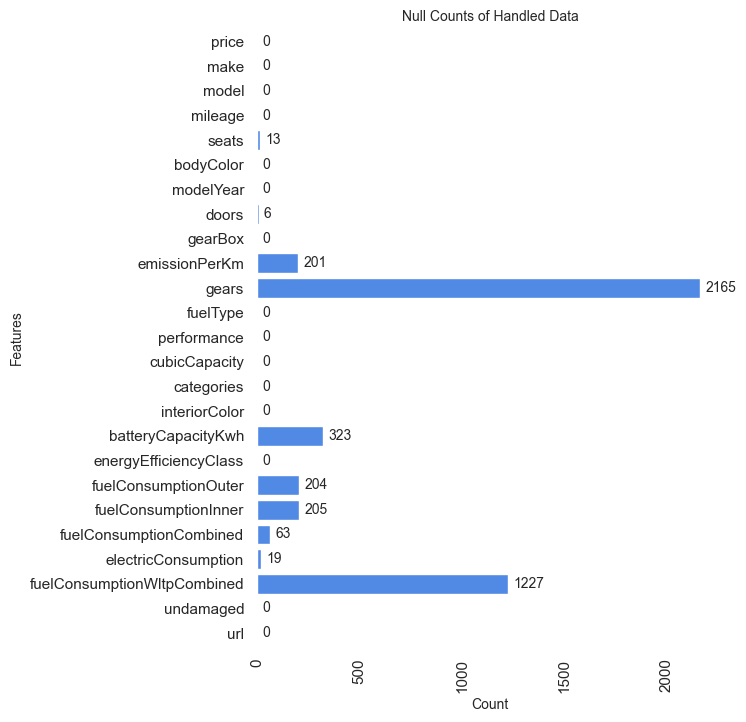

In [49]:
plot_nulls(df, 'Null Counts of Handled Data')

In [50]:
df.dropna(inplace=True)  # Drop rows with any remaining missing values
final_shape = df.shape[0]  # Store the final number of observations after dropping

# Reset the index
df.reset_index(drop=True, inplace=True)

print(f"Number of observations after handling missing data: {final_shape}")

Number of observations after handling missing data: 17482


## Handling Outliers

Detecting and removing outliers involves identifying data points that significantly differ from other observations in a dataset. One way to identify outliers is by using Z-scores, which measure how many standard deviations a data point is from the mean. In the provided function `remove_outliers_all_columns`, Z-scores are utilized to detect and remove outliers from numerical columns.

### Explanation of the steps involved in the function:
- For each numerical column in the DataFrame:
  - Z-scores are calculated for each data point in the column using the formula: 
    Z-score = (data point - mean) / standard deviation
  - Rows with Z-scores greater than the specified threshold (default thresh4ld = 5) are removed from the DataFrame.
- The function returns a DataFrame (`df_no_outliers`) where rows containing outliers in numerical columns have been removed.

### Using box plots in outlier detection:
- Box plots are effective visual tools that display the distribution of a dataset. They provide insights into the median, quartiles, and any potential outliers.
- Outliers in a box plot are data points that fall outside the range of Q1 - 1.5 * IQR to Q3 + 1.5 * IQR, where Q1 is the first quartile, Q3 is the third quartile, and IQR is the interquartile range.
- A threshold of 4 might be used in some cases to detect relatively extreme outliers. However, the choice of threshold often depends on the dataset and the specific context of the analysis. A higher threshold can be more lenient in identifying outliers.
- Even with a threshold of 4, there might still be outliers visible in box plots. This could occur due to:
  - The nature of the data: Some datasets may inherently contain extreme values that are not necessarily erroneous but are valid data points.
  - Influence of extreme but legitimate values: Certain data points might have a significant impact on the mean and standard deviation, causing other valid data points to be flagged as outliers.

To better visualize and understand the presence of outliers, using box plots alongside other statistical methods like Z-score-based outlier detection can provide a more comprehensive understanding of the data's distribution and help in making informed decisions regarding outlier treatment. Adjusting the threshold value or considering domain knowledge can also refine outlier detection methods.


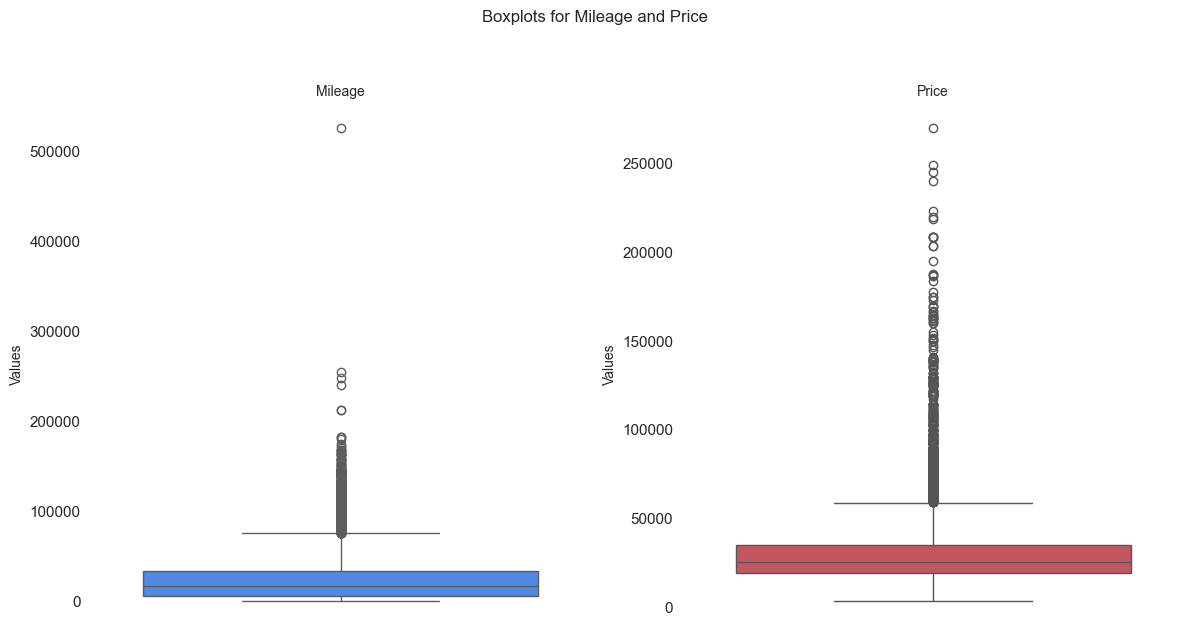

In [51]:
# Visualize features with the most outliers
def visualize_boxplots(df):
    """
    Generate boxplots using seaborn for the 'mileage' and 'price' columns in a single row.

    Parameters:
    - df : pandas DataFrame
        The input DataFrame containing the data.

    Returns:
    - None
        Displays boxplots for 'mileage' and 'price' columns.
    """
    # Creating subplots with specific layout
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Boxplot for 'mileage'
    sns.boxplot(data=df['mileage'], ax=axs[0])
    axs[0].set_title('Mileage')
    axs[0].set_ylabel('Values')

    # Boxplot for 'price'
    sns.boxplot(data=df['price'], ax=axs[1], color=config.COLOR_PALETTE[4])
    axs[1].set_title('Price')
    axs[1].set_ylabel('Values')

    plt.suptitle('Boxplots for Mileage and Price', y=1.05)
    plt.tight_layout()
    plt.show()

# Call the function
visualize_boxplots(df)

In [52]:
# Function to detect and remove outliers using z-score method for all numeric columns
def remove_outliers_all_columns(df, threshold=4):
    """
    Remove outliers from all numerical columns in the DataFrame based on Z-scores.

    Parameters:
    - df : pandas DataFrame
        The input DataFrame.
    - threshold : float, optional (default=5)
        The threshold value to determine outliers based on Z-scores.

    Returns:
    - df_no_outliers : pandas DataFrame
        The DataFrame with outliers removed from all numerical columns.
    """
    df_no_outliers = df.copy()
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
            df_no_outliers = df_no_outliers[z_scores < threshold]
    return df_no_outliers

# Remove outliers from the DataFrame for all numeric columns
df_no_outliers = remove_outliers_all_columns(df)

# Displaying the cleaned DataFrame without outliers
print("Original DataFrame:")
print(df.shape)

print("\nDataFrame after removing outliers from all numeric columns:")
print(df_no_outliers.shape)

Original DataFrame:
(17482, 25)

DataFrame after removing outliers from all numeric columns:
(16472, 25)


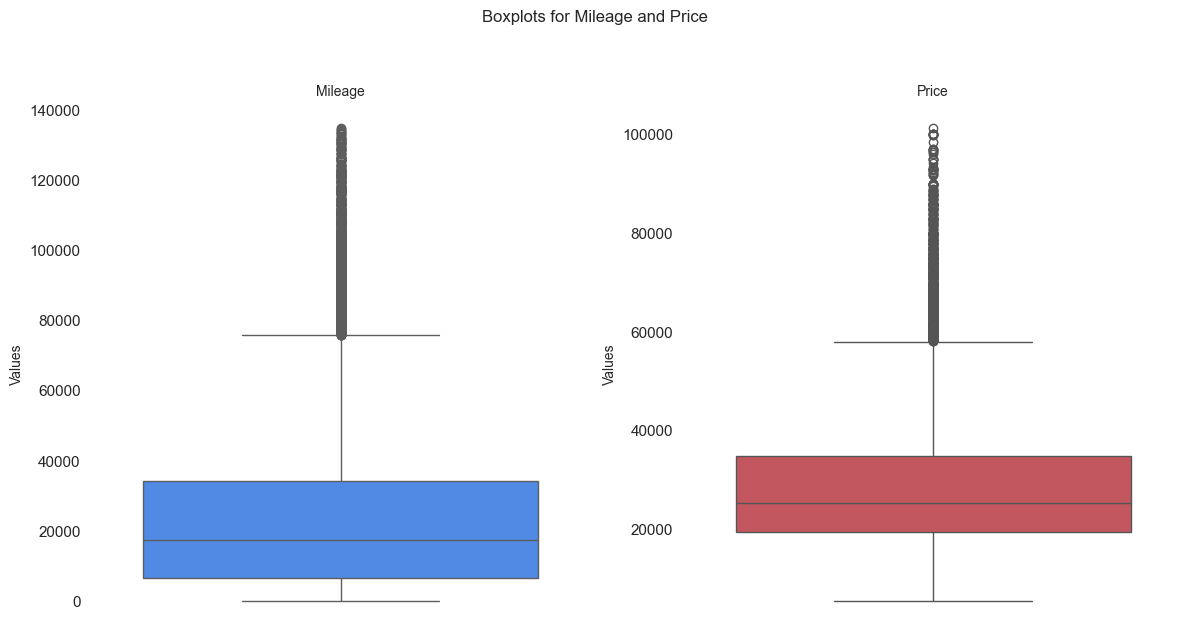

In [53]:
visualize_boxplots(df_no_outliers)
df = df_no_outliers

# Reset the index
df.reset_index(drop=True, inplace=True)

## Inconsistency check

Checking data inconsistency is crucial in a data science project as inconsistencies can significantly impact the reliability and accuracy of analyses and models. Inconsistent data can lead to erroneous conclusions, biased models, and unreliable predictions. Some reasons why checking data inconsistency is important and its effects on data science projects include:

1. **Quality of Analysis:** Inconsistent data can distort statistical analysis, leading to misleading insights and incorrect interpretations. It can affect the quality and validity of conclusions drawn from the data.

2. **Model Performance:** Inaccurate or inconsistent data can adversely impact machine learning models, causing biased predictions and reduced model performance. Models trained on inconsistent data may not generalize well to new or unseen data.

3. **Reliability and Trustworthiness:** Inconsistencies in the dataset can erode trust in the results obtained from data-driven decisions. It can affect the credibility of the analysis and the overall reliability of the project's outcomes.

4. **Decision Making:** Inaccurate or inconsistent data might lead to flawed business decisions if stakeholders rely on flawed insights derived from the data.

5. **Data Integration:** Inconsistent data can create challenges during data integration processes, making it difficult to merge or combine datasets acm analyses.


### Potential Inconsistency Between Mileage and Model Year

In a dataset related to vehicles, inconsistencies between mileage and modelYear may arise due to various reasons:

1. **Data Entry Errors:** Human errors during data collection or input might result in incorrect entries for either mileage or model year, leading to inconsistencies.

2. **Tampering or Manipulation:** Deliberate alterations or manipulation of data could create discrepancies between the recorded mileage and the specified model year.

3. **Anomalies and Outliers:** Outliers or anomalies in the dataset, such as exceptionally high or low mileage for a specific model year, could indicate potential errors or inaccuracies.

4. **Vehicle Usage Patterns:** Unusual driving patterns, irregular maintenance, or atypical usage of vehicles might cause discrepancies between the actual mileage and the expected mileage for a given model year.

Addressing these inconsistencies is crucial for ensuring the accuracy and reliability of analyses, especially in predictive modeling or determining vehicle conditions. Identification and resolution of such discrepancies can enhance the quality and trustworthiness of the dataset, leading to more accurate data-driven insights and conclusions.

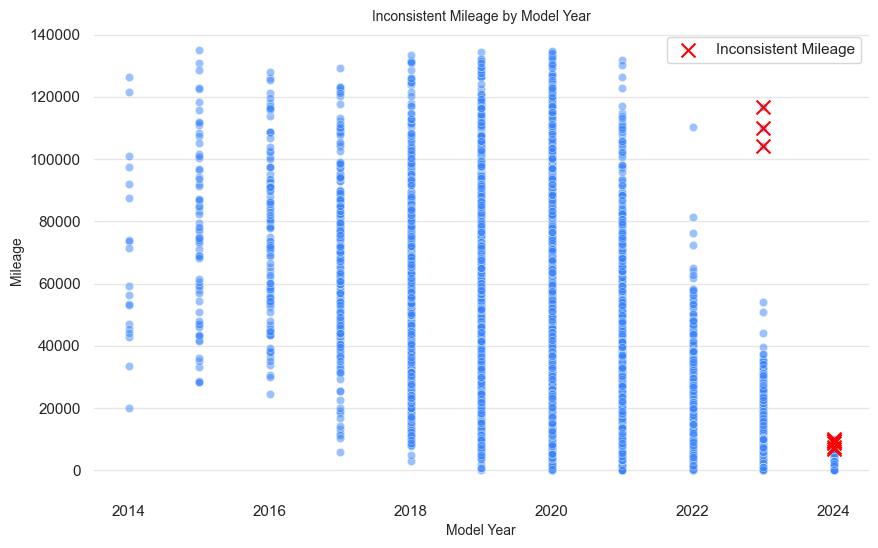

In [54]:
# Calculate average mileage for each model year
average_mileage_by_year = df.groupby('modelYear')['mileage'].mean().reset_index()

# Merge the average mileage values back into the original DataFrame
df_with_avg_mileage = pd.merge(df, average_mileage_by_year, on='modelYear', suffixes=('', '_avg'))

# Identify rows with mileage > average * 10
inconsistent_mileage = df_with_avg_mileage[df_with_avg_mileage['mileage'] > (df_with_avg_mileage['mileage_avg'] * 10)]

# Plotting
plt.figure(figsize=(10, 6))
plt_modelYearvsMileage = sns.scatterplot(data=df_with_avg_mileage, x='modelYear', y='mileage', alpha=0.5)
plt.scatter(data=inconsistent_mileage, x='modelYear', y='mileage', color='red', marker='x', s=100, label='Inconsistent Mileage')
plt.legend()
plt.grid(axis='y')
plt.title('Inconsistent Mileage by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Mileage')
plt.show()

In [55]:
# Calculate average mileage for each model year
average_mileage_by_year = df.groupby('modelYear')['mileage'].transform('mean')

# Identify rows with mileage > average * 10
inconsistent_mileage_indices = df[df['mileage'] > (average_mileage_by_year * 10)].index

# Drop rows with inconsistent mileage
df = df.drop(inconsistent_mileage_indices)

# Reset the index
df.reset_index(drop=True, inplace=True)

print(f"Number of inconsistent observations {inconsistent_mileage.shape[0]}")

Number of inconsistent observations 10


### Potential Inconsistencies in Fuel Consumption

The comparison between `fuelConsumptionInner` and `fuelConsumptionOuter` helps identify potential inconsistencies in fuel consumption rates under different driving conditions. In most cases, `fuelConsumptionInner` (typically representing urban driving) tends to be higher than `fuelConsumptionOuter` (representing highway or extra-urban driving) due to the nature of driving environments.

However, when instances occur where `fuelConsumptionInner` is considerably lower than a certain percentage of `fuelConsumptionOuter`, it might indicate a potential inconsistency or anomaly in the data. For instance, in this analysis, we've considered cases where `fuelConsumptionInner` is less than 63% of `fuelConsumptionOuter`.

This discrepancy could arise due to data recording errors, mislabeling, or specific driving conditions that contradict the typical behavior seen in fuel consumption data. Further investigation or domain-specific knowledge might be necessary to validate these discrepancies and determine if they represent genuine anomalies or errors in the dataset.


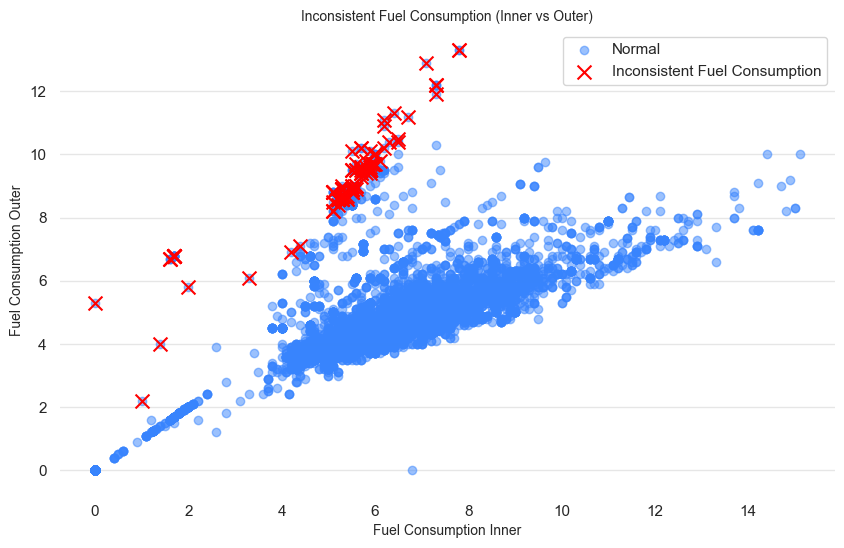

In [56]:
# Identify rows where fuelConsumptionInner is smaller than fuelConsumptionOuter
inconsistent_fuel = df[df['fuelConsumptionInner'] < df['fuelConsumptionOuter']*0.63]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(data=df, x='fuelConsumptionInner', y='fuelConsumptionOuter', alpha=0.5, label='Normal')
plt.scatter(data=inconsistent_fuel, x='fuelConsumptionInner', y='fuelConsumptionOuter', color='red', marker='x', s=100, label='Inconsistent Fuel Consumption')
plt.legend()
plt.grid(axis='y')
plt.title('Inconsistent Fuel Consumption (Inner vs Outer)')
plt.xlabel('Fuel Consumption Inner')
plt.ylabel('Fuel Consumption Outer')
plt.show()

In [57]:
# Identify rows where fuelConsumptionInner is substantially smaller than fuelConsumptionOuter
inconsistent_fuel_indices = df[df['fuelConsumptionInner'] < df['fuelConsumptionOuter'] * 0.63].index

# Drop rows with inconsistent fuel consumption
df = df.drop(inconsistent_fuel_indices)

# Reset the index
df.reset_index(drop=True, inplace=True)

print(f"Number of inconsistent observations {inconsistent_fuel.shape[0]}")

Number of inconsistent observations 170


### Potential Inconsistencies in Electric Consumption
If a vehicle is not electric, it should not consume electricity. As can be seen below, there is no inconsistency in this regard.

In [58]:
# Identify rows where fuelType is not electric but electricConsumption is present
inconsistent_electric = df[(df['fuelType'] != 'electric') & df['electricConsumption'] != 0]

print(f"Number of inconsistent observation for fuelType and electricConsumption: {inconsistent_electric.shape[0]}")

Number of inconsistent observation for fuelType and electricConsumption: 0


# Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is an essential preliminary step in understanding and summarizing the characteristics of a dataset. It involves analyzing and visualizing data to uncover patterns, trends, and relationships within the dataset.

The primary goals of EDA are to gain insights, identify patterns, and summarize the main characteristics of the data before performing more complex analyses or modeling. This process aids in understanding the structure of the dataset and determining potential areas for further investigation.

Key components of EDA include:

1. **Descriptive Statistics:** Computing summary statistics such as mean, median, standard deviation, etc., to describe the central tendency and dispersion of data.

2. **Data Visualization:** Creating visual representations like histograms, boxplots, scatter plots, etc., to explore distributions, relationships, and outliers within the dataset.

3. **Correlation Analysis:** Examining correlations between variables to understand dependencies and potential predictive relationships.

We gain a better understanding of the dataset's characteristics, enabling them to make informed decisions about preprocessing steps, feature engineering, and model selection. This process helps in formulating hypotheses and guiding further analyses for valuable insights.


In [59]:
def calculate_skewness(data, column_name):
    """
    Calculate the skewness of a specified numerical column in the dataset.

    Parameters:
    - data : pandas DataFrame
        The DataFrame containing the dataset.
    - column_name : str
        The name of the numerical column to calculate skewness for.

    Returns:
    - float
        Skewness value of the specified column.
    """
    skew_value = skew(data[column_name])
    return skew_value


In [60]:
def plot_distribution_and_scatter(df, column):
    """
    This function generates a side-by-side visualization to explore the distribution of a numerical column
    in the DataFrame using a histogram and examines its relationship with the 'price' column through a scatter plot.

    Parameters:
    - df : pandas DataFrame
        The DataFrame containing the data to be visualized.
    - column : str
        The name of the column to be visualized.

    The function displays two subplots:
    - The first subplot exhibits a histogram showcasing the distribution of the specified column. 
      It includes vertical lines representing the median and mean values of the column.
    - The second subplot shows a scatter plot indicating the relationship between the specified column and the 'price' column.

    Args:
    - df : pandas DataFrame
        The DataFrame containing the data.
    - column : str
        The name of the column to be visualized.
    """
    # Plotting the histogram (distribution)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=column)
    plt.axvline(df[column].median(), color='black', linewidth=1.5, label='Median')
    plt.axvline(df[column].mean(), color='red', linewidth=1.5, label='Mean')
    plt.title(f'Distribution of {column.capitalize()}')
    plt.xlabel(f'{column.capitalize()}')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.legend()

    # Scatter plot to examine relation between column and price
    plt.subplot(1, 2, 2)
    plt.scatter(df[column], df['price'], s=8, alpha=0.7, c=config.COLOR_PALETTE[4])
    plt.title(f'Relationship between {column.capitalize()} and Price')
    plt.xlabel(f'{column.capitalize()}')
    plt.ylabel('Price (€)')
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.show()


In [61]:
def plot_pie_chart(dataframe, column_name):
    """
    Generate a pie chart based on the specified column in the given DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to be visualized in the pie chart.

    Returns:
    None: Displays a pie chart using matplotlib.
    """
    # Count occurrences of each unique value in the specified column
    counts = dataframe[column_name].value_counts()

    # Plotting the pie chart
    plt.figure(figsize=(6, 4))  # Set the figure size
    patches, texts, autotexts = plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title(f'Pie Chart for {column_name}', pad=20)

    # Set label texts color to white
    for text in autotexts:
        text.set_color('white')

    plt.show()

In [62]:
def plot_grouped_histograms(dataframe, column_name, group_by_column):
    """
    Generate histograms for the specified column within each group formed by another column in the given DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to be visualized in histograms.
    group_by_column (str): The name of the column used for grouping the data.

    Returns:
    None: Displays histograms using matplotlib.
    """
    grouped = dataframe.groupby(group_by_column)
    num_groups = len(grouped)
    num_cols = 2
    num_rows = (num_groups + 1) // num_cols
    plt.figure(figsize=(8, 4 * num_rows))

    for i, (group_name, group_data) in enumerate(grouped):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.hist(group_data[column_name], bins=25, alpha=0.7, color=config.COLOR_PALETTE[np.random.randint(0,5)])
        plt.title(f'Histogram of {column_name} for {group_by_column} = {group_name}')
        plt.xlabel(column_name)
        plt.ylabel('Frequency')
        # Show only horizontal gridlines
        plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

In [63]:
def calculate_and_print_stats(df, column_name):
    """
    Calculate and Print Summary Statistics
    
    This function calculates and prints the skewness and other important summary statistics for a specified column in a DataFrame.
    
    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - column_name (str): The name of the column for which statistics will be calculated and printed.
    
    Returns:
    None
    """
    
    # Calculate skewness
    skewness = skew(df[column_name])
    print(f"Skewness of '{column_name}' column: {skewness}")

    # Other important summary statistics
    other_stats = df[column_name].describe()
    print("\nOther important summary statistics:")
    print(f"Mean of '{column_name}': {other_stats['mean']}")
    print(f"Median of '{column_name}': {other_stats['50%']}")
    print(f"Minimum value of '{column_name}': {other_stats['min']}")
    print(f"Maximum value of '{column_name}': {other_stats['max']}")

In [64]:
def calculate_and_print_categorical_stats(df, column_name):
    """
    Calculate and Print Summary Statistics for Categorical Data
    
    This function calculates and prints summary statistics for a specified categorical column in a DataFrame.
    
    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - column_name (str): The name of the categorical column for which statistics will be calculated and printed.
    
    Returns:
    None
    """
    # Check if the column is categorical
    if df[column_name].dtype == 'object':
        # Count of each category
        category_counts = df[column_name].value_counts()
        print(f"Counts of categories in '{column_name}':")
        print(category_counts)
        
        # Number of unique categories
        unique_categories = df[column_name].nunique()
        print(f"\nNumber of unique categories in '{column_name}': {unique_categories}")
        
        # Mode (most frequent category)
        mode_category = df[column_name].mode().values[0]
        mode_count = category_counts[mode_category]
        print(f"\nMost frequent category in '{column_name}': {mode_category} (Count: {mode_count})")
        
    else:
        print(f"The column '{column_name}' is not categorical.")

### Feature: price

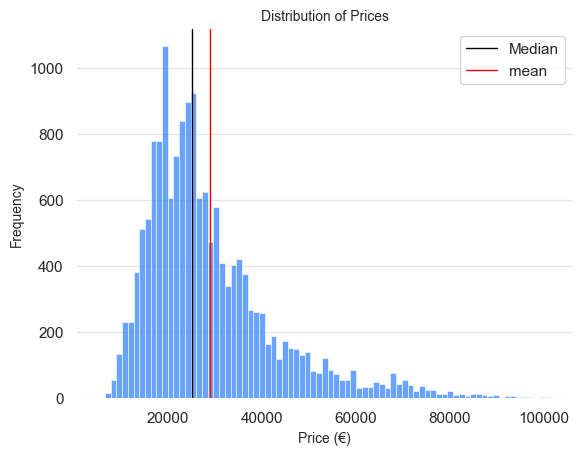

In [65]:
# Plotting the histogram
sns.histplot(data=df, x='price')
plt.axvline(df['price'].median(), color='black', linewidth=1, label='Median')
plt.axvline(df['price'].mean(), color='red', linewidth=1, label='mean')
plt.title('Distribution of Prices')
plt.xlabel('Price (€)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.legend()
plt.show()

In [66]:
# Calculate summary statistics
calculate_and_print_stats(df, 'price')

Skewness of 'price' column: 1.5570073925903214

Other important summary statistics:
Mean of 'price': 28981.79333415173
Median of 'price': 25230.0
Minimum value of 'price': 5490.0
Maximum value of 'price': 101290.0


The `price` feature of the dataset is distributed mostly between **15000** and **30000** euros. The distribution's skewness is **1.556**, which indicates it is significantly far from the skewness value of 0 in a normal distribution.

Skewness measures the asymmetry of the distribution. A positive skewness value (like 1.556 in this case) indicates that the tail of the distribution is longer on the right side than the left side. Therefore, the distribution is **right-skewed** and **not symmetic**.

Additionally, it's mentioned that the median (which represents the middle value when the data is ordered) is smaller than the mean. In a right-skewed distribution, the mean is typically greater than the median because the right tail (higher values) pulls the mean in that direction.

### Feature: mileage

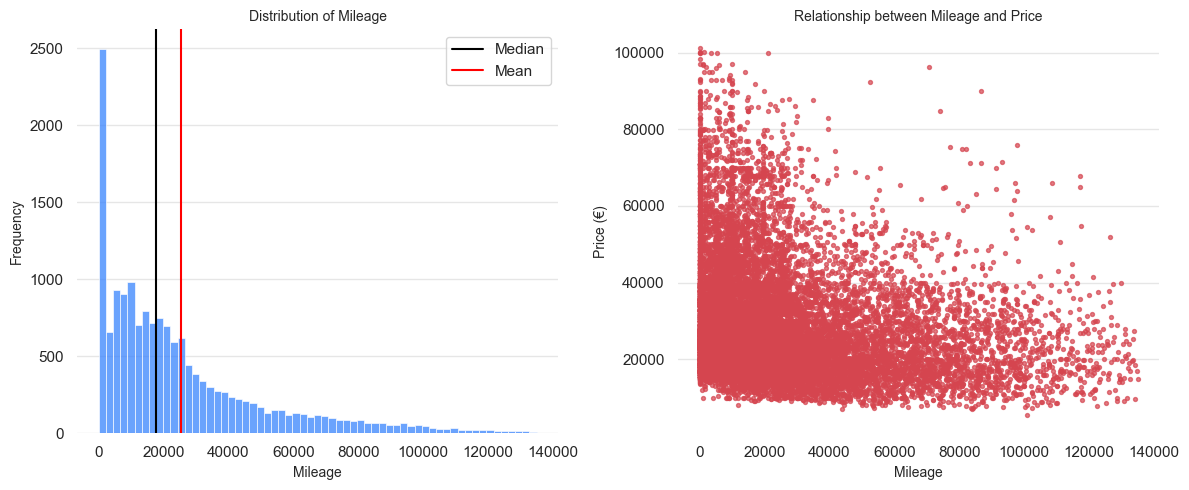

In [67]:
plot_distribution_and_scatter(df, 'mileage')

In [68]:
# Calculate summary statistics
calculate_and_print_stats(df, 'mileage')

Skewness of 'mileage' column: 1.5363984218295503

Other important summary statistics:
Mean of 'mileage': 25260.13331696538
Median of 'mileage': 17601.0
Minimum value of 'mileage': 0.0
Maximum value of 'mileage': 135000.0


In [69]:
config.ASYMMETRIC_FEATURES.append('mileage')

Histogram represents the distribution of kilometers for vehicles.
Most vehicles have mileage below 20,000, as indicated by the height of the first bar.
The average mileage is higher than the median mileage. And skewness of the feature is 1.535. These indicate a right-skewed distribution. At lower kilometer and price levels, there is a concentration of data points. There is a general trend of decreasing price as the mileage increases, but this doesn’t represent a very strong linear relationship.

### Feature: emissionPerKm

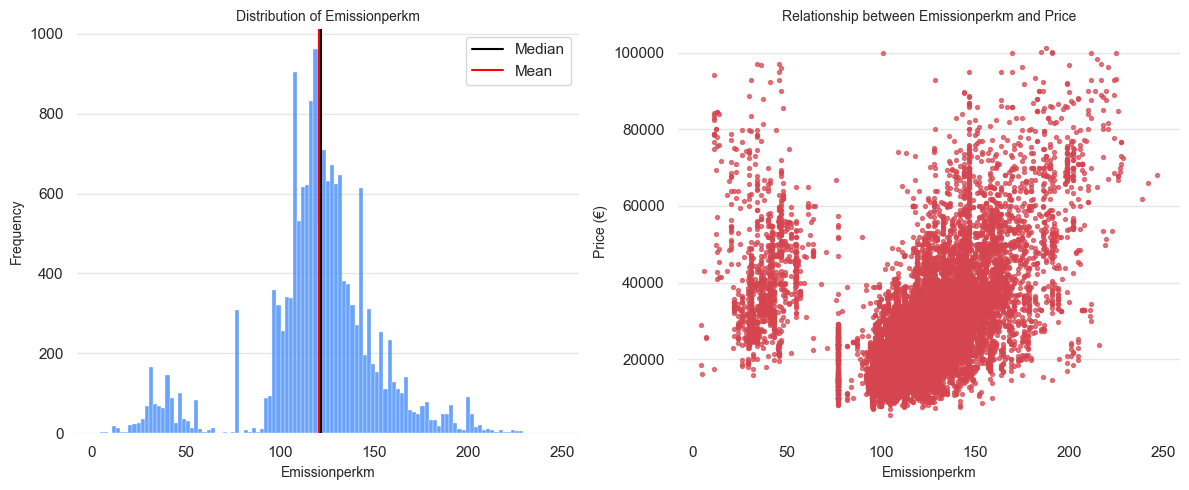

In [70]:
plot_distribution_and_scatter(df, 'emissionPerKm');

In [71]:
# Calculate summary statistics
calculate_and_print_stats(df, 'emissionPerKm')

Skewness of 'emissionPerKm' column: -0.6369985899097571

Other important summary statistics:
Mean of 'emissionPerKm': 120.97989810950159
Median of 'emissionPerKm': 122.0
Minimum value of 'emissionPerKm': 4.0
Maximum value of 'emissionPerKm': 247.0


When we look at the distribution of this feature, we can infer that it is close to the normal distribution, even if it is not perfect. When we compare it with Price, there is no obvious relationship between the two features. In general, we can conclude that vehicles have emissions between **100** and **150 per kilometer**.

### Feature: performance

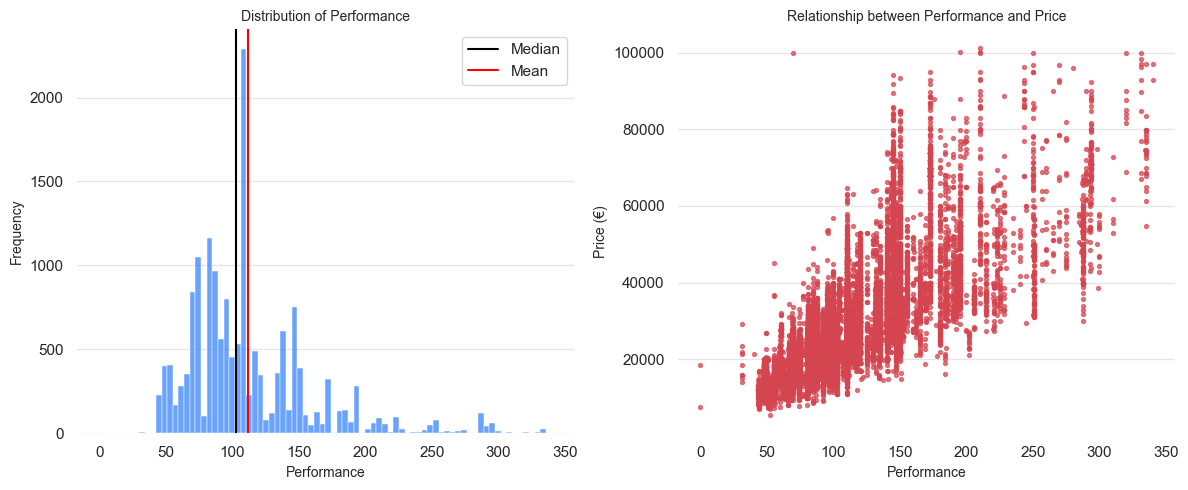

In [72]:
plot_distribution_and_scatter(df, 'performance')

In [73]:
# Calculate summary statistics
calculate_and_print_stats(df, 'performance')

Skewness of 'performance' column: 1.5570843922379394

Other important summary statistics:
Mean of 'performance': 112.06764055978394
Median of 'performance': 103.0
Minimum value of 'performance': 0.0
Maximum value of 'performance': 340.0


In [74]:
config.ASYMMETRIC_FEATURES.append('performance')

We can see that vehicle performance in kW has a **positive relationship** with vehicle price. In general, the increase in performance has resulted in an increase in price. Vehicle performance is generally spread around **100 kW**. In addition, in this graph, where it is more difficult to see the asymmetry in the visual, the metrics of skewness and median being smaller than the average mean that we will put it into a logarithmic transformation in the future.

### Feature: cubicCapacity

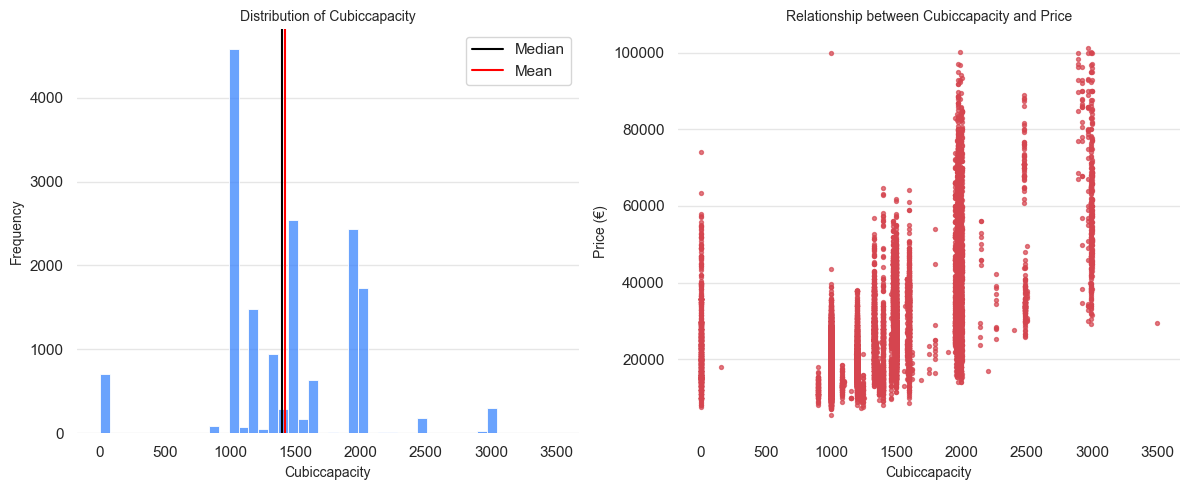

In [75]:
plot_distribution_and_scatter(df, 'cubicCapacity')

Not all numeric properties, but there is something I want to show in the `cubicCapacity` property. Although most of the features we have are numerical features, as can be seen, they do not show a continuous behavior. This is also the case with other numerical features whose distribution I have not shown. The data is grouped at certain values. With this feature we can see a weak positive relationship between price. However, I will revisit similar numerical features using the grouping method in the `Feature engineering` section. 

In addition, the reason for the accumulation at 0 is electric vehicles. Electric cars don’t use CC numbers because of the way that the engine/motor works. Electric cars use motors, not engines.

In [76]:
# Calculate summary statistics
calculate_and_print_stats(df, 'cubicCapacity')

Skewness of 'cubicCapacity' column: -0.050996095291972236

Other important summary statistics:
Mean of 'cubicCapacity': 1417.587895899828
Median of 'cubicCapacity': 1398.0
Minimum value of 'cubicCapacity': 0.0
Maximum value of 'cubicCapacity': 3498.0


### Feature: batteryCapacityKwh

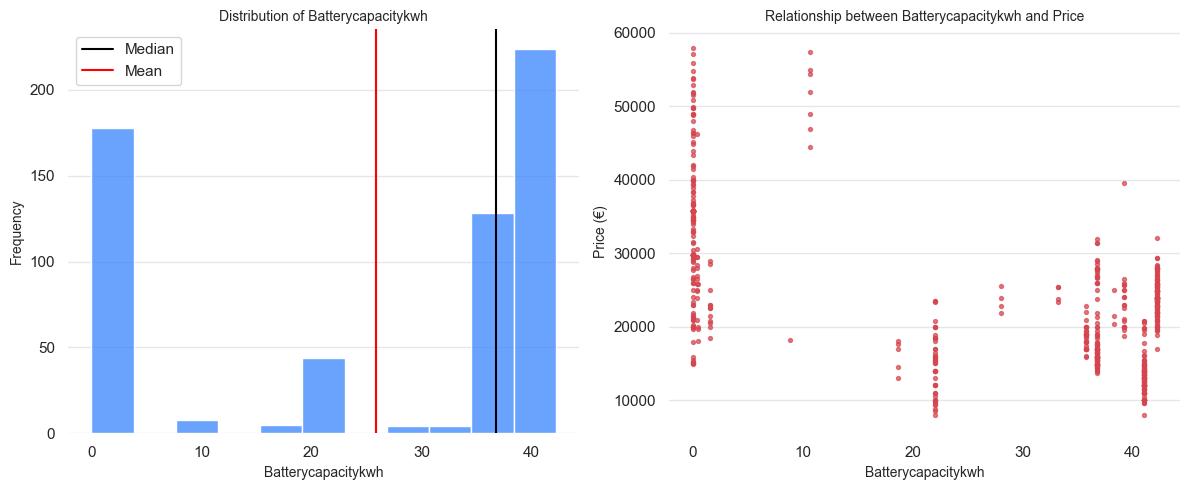

In [77]:
plot_distribution_and_scatter(df[df['fuelType'] == 'electric'], 'batteryCapacityKwh')

In [78]:
# Calculate summary statistics
calculate_and_print_stats(df[df['fuelType'] == 'electric'], 'batteryCapacityKwh')

Skewness of 'batteryCapacityKwh' column: -0.6013758464902113

Other important summary statistics:
Mean of 'batteryCapacityKwh': 25.84605042016807
Median of 'batteryCapacityKwh': 36.8
Minimum value of 'batteryCapacityKwh': 0.0
Maximum value of 'batteryCapacityKwh': 42.2


Upon reviewing the distinct attributes of electric vehicles, we've observed numerous features recorded as 0, despite their non-zero nature. Consequently, these entries fail to accurately depict the actual scenario. Instead of showcasing attributes unique to various electric vehicles, the plan is to eliminate these columns, opting for a singular 'is_electric' property to represent this distinction more effectively.

### Feature: fuelConsumptionOuter

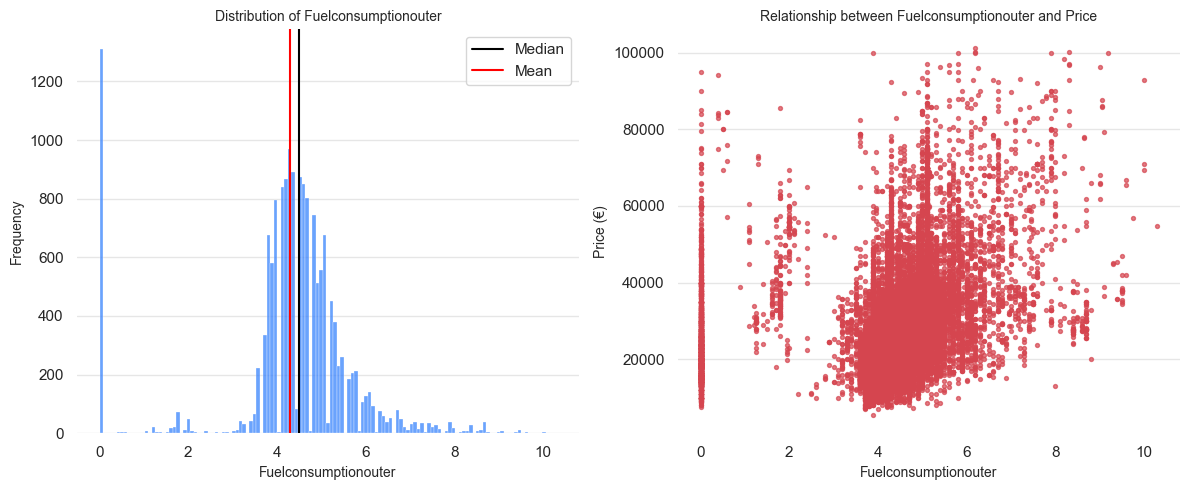

In [79]:
plot_distribution_and_scatter(df, 'fuelConsumptionOuter')

In [80]:
# Calculate summary statistics
calculate_and_print_stats(df, 'fuelConsumptionOuter')

Skewness of 'fuelConsumptionOuter' column: -1.2275848712659705

Other important summary statistics:
Mean of 'fuelConsumptionOuter': 4.300011048305916
Median of 'fuelConsumptionOuter': 4.5
Minimum value of 'fuelConsumptionOuter': 0.0
Maximum value of 'fuelConsumptionOuter': 10.3


Again, there does not appear to be a specific relationship between these features. The skewness seems high, but this is because electric vehicles have 0 consumption. So logarithmic conversion doesn't make sense for this feature. Generally distributed around 4.4 Liters.

### Feature: fuelConsumptionInner

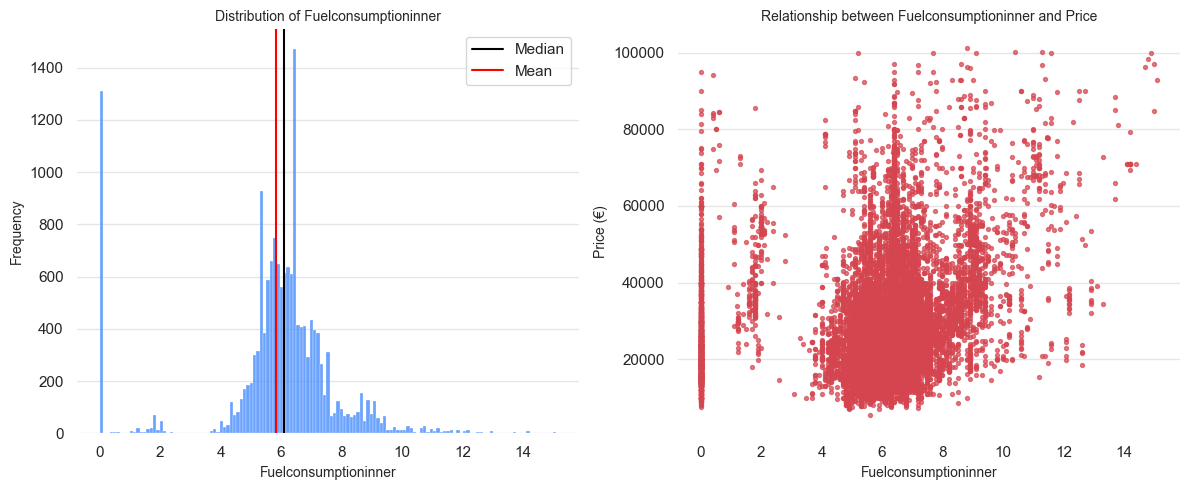

In [81]:
plot_distribution_and_scatter(df, 'fuelConsumptionInner')

In [82]:
# Calculate summary statistics
calculate_and_print_stats(df, 'fuelConsumptionInner')

Skewness of 'fuelConsumptionInner' column: -1.1063693752529247

Other important summary statistics:
Mean of 'fuelConsumptionInner': 5.849164620672723
Median of 'fuelConsumptionInner': 6.1
Minimum value of 'fuelConsumptionInner': 0.0
Maximum value of 'fuelConsumptionInner': 15.1


This feature has similar implications as the previous one. Generally distributed around 6 Liters.

### Feature: fuelConsumptionCombined

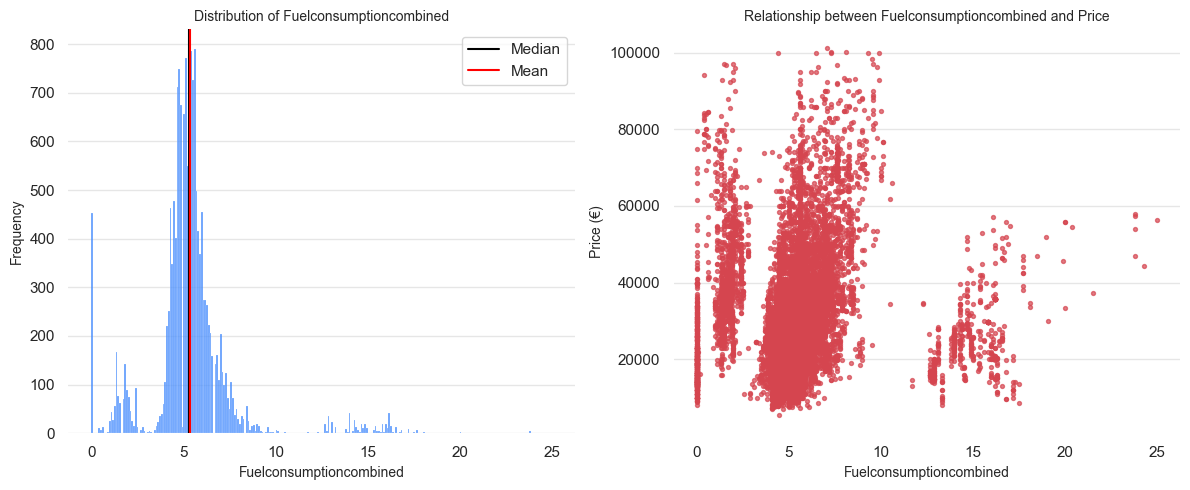

In [83]:
plot_distribution_and_scatter(df, 'fuelConsumptionCombined')

In [84]:
# Calculate summary statistics
calculate_and_print_stats(df, 'fuelConsumptionCombined')

Skewness of 'fuelConsumptionCombined' column: 1.8653491713678705

Other important summary statistics:
Mean of 'fuelConsumptionCombined': 5.346317824637858
Median of 'fuelConsumptionCombined': 5.3
Minimum value of 'fuelConsumptionCombined': 0.0
Maximum value of 'fuelConsumptionCombined': 25.0


fuelConsumptionCombined with other fuel properties shows similar behavior. This time it has a lower skewness value due to fewer observations collected at 0. Generally distributed around 5 Liters.

### Feature: make

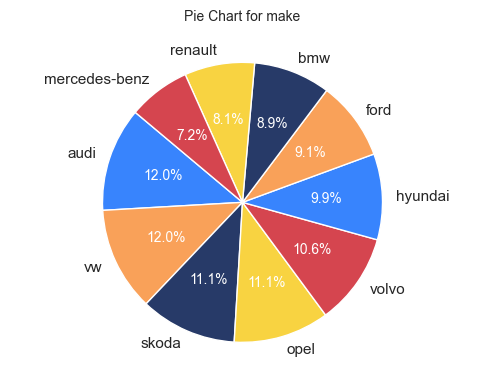

In [85]:
plot_pie_chart(df, 'make')

Initially, an equal proportion of data (10% each) was collected from various brands during the data collection phase. However, due to the cleaning process, these proportions have shifted notably. It's essential to note that despite these shifts, the data distribution remains sufficiently balanced, avoiding significant data imbalances.

Notably, the Audi brand experienced the least reduction in data volume, while the substantial data loss in the Mercedes-Benz brand was less desirable. To visualize this proportional shift effectively, a pie chart proves to be the most suitable grap."

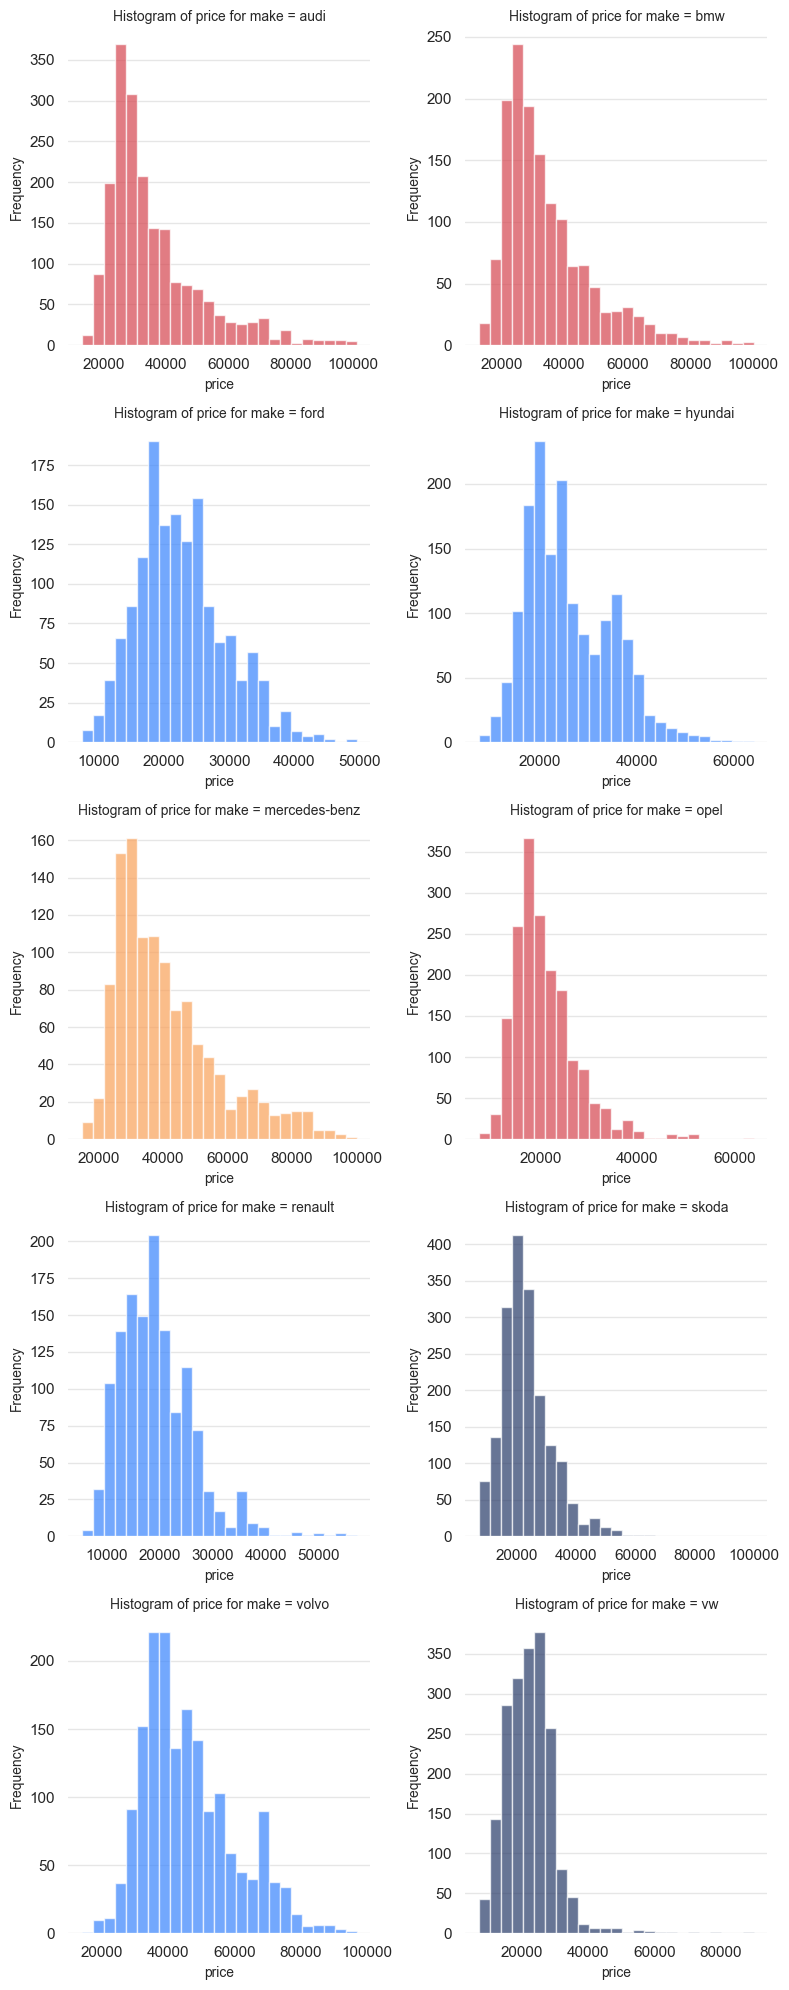

In [86]:
plot_grouped_histograms(df, 'price', 'make')

Analyzing the distribution of car prices across different brands by grouping vehicles based on their brand reveals insightful patterns. This approach, utilizing separate histograms for each brand, facilitates nuanced insights.

Notably, Volvo stands out with the highest price range across all brands, averaging around 40 thousand euros or more per vehicle. Conversely, Renault typically offers more budget-friendly vehicles, followed by Opel and Ford. These observations underscore the significance of car brands as a determining factor in pricing.

In [87]:
# Calculate summary statistics
calculate_and_print_categorical_stats(df, 'make')

Counts of categories in 'make':
make
audi             1959
vw               1955
skoda            1815
opel             1802
volvo            1722
hyundai          1617
ford             1487
bmw              1446
renault          1319
mercedes-benz    1170
Name: count, dtype: int64

Number of unique categories in 'make': 10

Most frequent category in 'make': audi (Count: 1959)


### Feature: bodyColor

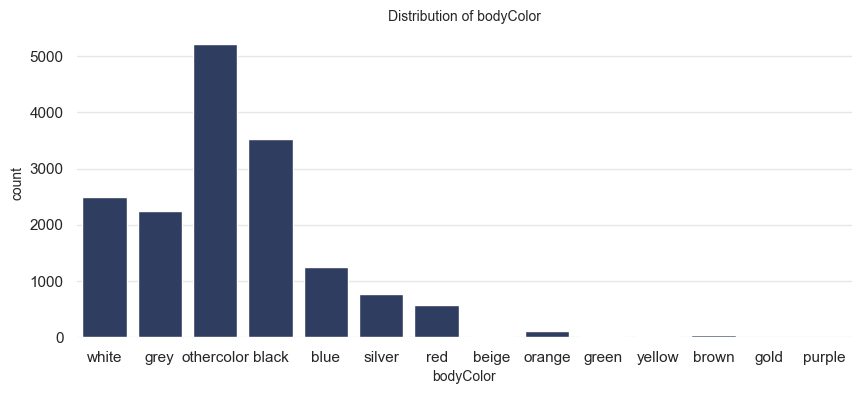

In [88]:
plt.figure(figsize=(10, 4))  # Setting the figure size
sns.countplot(data=df, x='bodyColor', color=config.COLOR_PALETTE[2])  # Creating the count plot
plt.title("Distribution of bodyColor")
plt.grid(axis='y')
plt.show()

Observing the data, it's evident that there's a scarcity of examples beyond the red spectrum of colors. Due to the limited representation of these values, they fail to provide substantial information. Hence, let's consolidate them as 'rare' for better analysis.

In [89]:
# Define a list of colors to be updated to 'rare'
colors_to_update = ['beige', 'orange', 'green', 'yellow', 'brown', 'gold', 'purple']

# Locate rows where 'bodyColor' matches any color from the list and set them to 'rare'
df.loc[df['bodyColor'].isin(colors_to_update), 'bodyColor'] = 'rare'

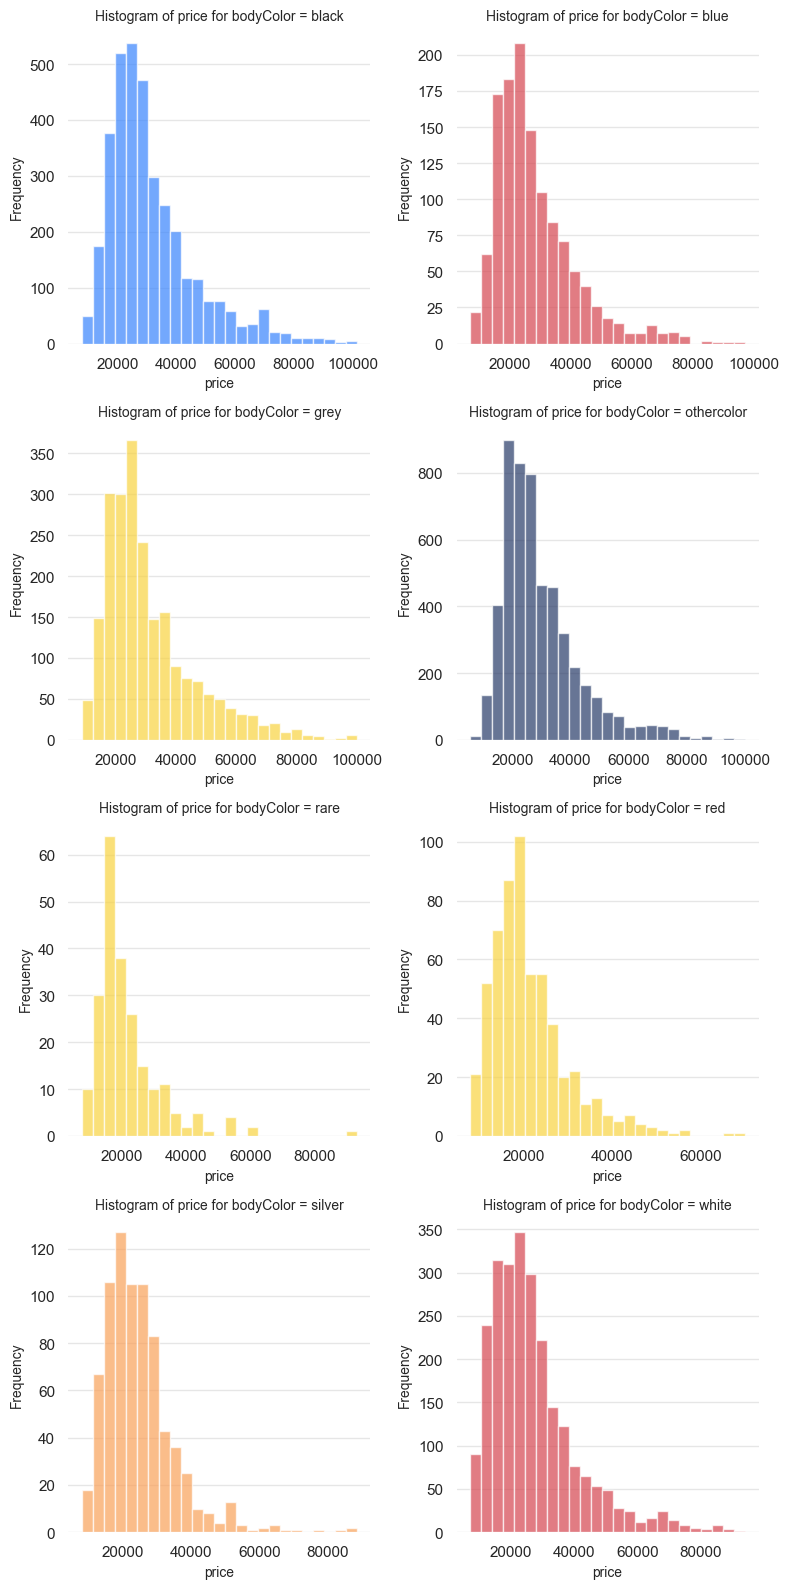

In [90]:
plot_grouped_histograms(df, 'price', 'bodyColor')

When analyzing the relationship between vehicle prices and their body colors through grouping, intriguing observations come to light. Upon close examination, the patterns discerned within these groupings exhibit remarkable uniformity across different body colors. This uniformity suggests that there exists a limited variance in prices associated with distinct colors, leading us to an interesting inference: the influence of body color on pricing appears to be rather subtle or weak.

The data gleaned from this analysis signifies a lack of significant price differentiation attributed to various body colors among vehicles. While certain color preferences may exist among consumers, these findings imply that the impact of color choice on pricing might not be as pronounced as other influential factors in determining the price of a vehicle.

In [91]:
# Calculate summary statistics
calculate_and_print_categorical_stats(df, 'bodyColor')

Counts of categories in 'bodyColor':
bodyColor
othercolor    5215
black         3529
white         2487
grey          2237
blue          1256
silver         765
red            579
rare           224
Name: count, dtype: int64

Number of unique categories in 'bodyColor': 8

Most frequent category in 'bodyColor': othercolor (Count: 5215)


### Feature: gearBox

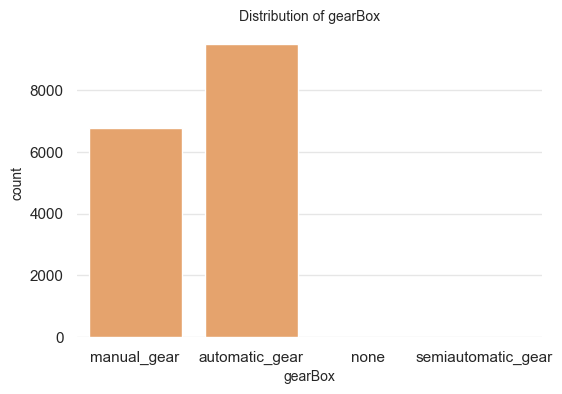

In [92]:
plt.figure(figsize=(6, 4))  # Setting the figure size
sns.countplot(data=df, x='gearBox', color=config.COLOR_PALETTE[1])  # Creating the count plot
plt.title("Distribution of gearBox")
plt.grid(axis='y')
plt.show()

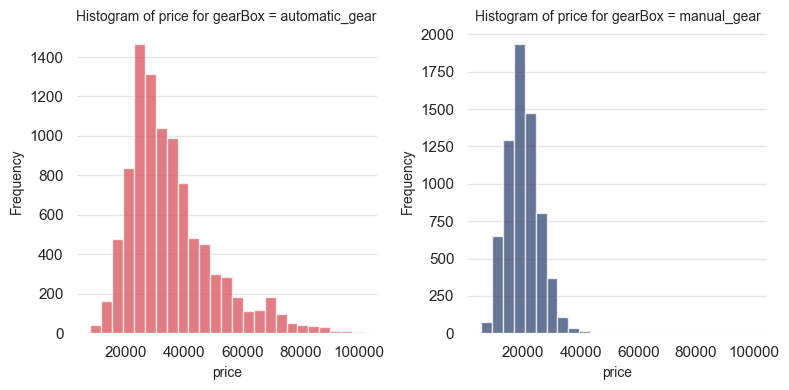

In [93]:
plot_grouped_histograms(df[df['gearBox'].isin(['manual_gear', 'automatic_gear'])], 'price', 'gearBox')

In strategizing for future analysis, I made a conscious decision to exclude visualizing data related to 'semi_auto' due to its scarcity in examples, and 'none,' a category likely to contain erroneous or incomplete entries. As these categories lack substantial representation, they might skew or inadequately contribute to any meaningful analysis. Focusing on the remaining categories, namely 'manual_gear' and 'automatic_gear,' reveals compelling insights into the relationship between transmission types and vehicle pricing.

The deliberate exclusion of 'semi_auto' and 'none' categories stemmed from their limited presence within the dataset, which could potentially compromise the reliability and interpretability of any derived insights. While these categories may hold relevance in specific contexts, their scarcity within the dataset might not render them conducive for drawing significant conclusions.

The data hints at a trend where automatic vehicles tend to command higher prices compared to their manual counterparts. This intriguing observation suggests that the type of transmission plays a noteworthy role in pricing, wherein automatic vehicles are often associated with relatively higher price ranges.

In [94]:
# Calculate summary statistics
calculate_and_print_categorical_stats(df, 'gearBox')

Counts of categories in 'gearBox':
gearBox
automatic_gear        9498
manual_gear           6776
none                    12
semiautomatic_gear       6
Name: count, dtype: int64

Number of unique categories in 'gearBox': 4

Most frequent category in 'gearBox': automatic_gear (Count: 9498)


### Feature: fuelType

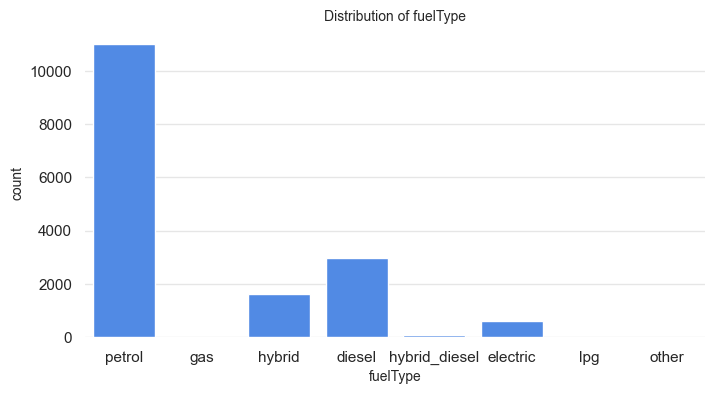

In [95]:
plt.figure(figsize=(8, 4))  # Setting the figure size
sns.countplot(data=df, x='fuelType', color=config.COLOR_PALETTE[0])  # Creating the count plot
plt.title("Distribution of fuelType")
plt.grid(axis='y')
plt.show()

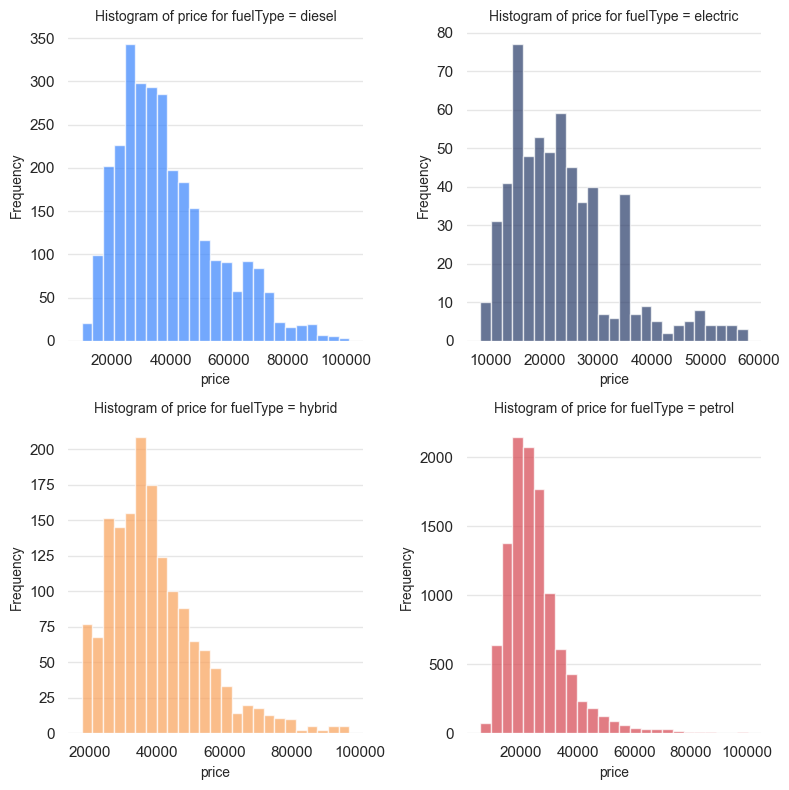

In [96]:
plot_grouped_histograms(df[df['fuelType'].isin(['petrol', 'electric', 'hybrid', 'diesel'])], 'price', 'fuelType')

The countplot vividly illustrates an insufficient number of samples for certain fuel types, indicating a likelihood of their exclusion during the feature selection phase. Upon contrasting the popularity of fuel types with their respective prices, noteworthy insights emerge. In general, hybrid vehicles command the highest average price, closely trailed by diesel counterparts, which exhibit a pricing pattern akin to petrol-fueled vehicles. However, the latter slightly edge out petrol vehicles with a marginally lower price.

Electric vehicles emerge as the most affordable among these four classes. Yet, it's crucial to consider specific vehicle brands within these categories. It's worth noting that this outcome might have varied if vehicles focused solely on electric propulsion, such as Tesla models, were included in the analysis.

In [97]:
# Calculate summary statistics
calculate_and_print_categorical_stats(df, 'fuelType')

Counts of categories in 'fuelType':
fuelType
petrol           11021
diesel            2981
hybrid            1601
electric           595
hybrid_diesel       72
gas                 19
lpg                  2
other                1
Name: count, dtype: int64

Number of unique categories in 'fuelType': 8

Most frequent category in 'fuelType': petrol (Count: 11021)


### Feature: categories

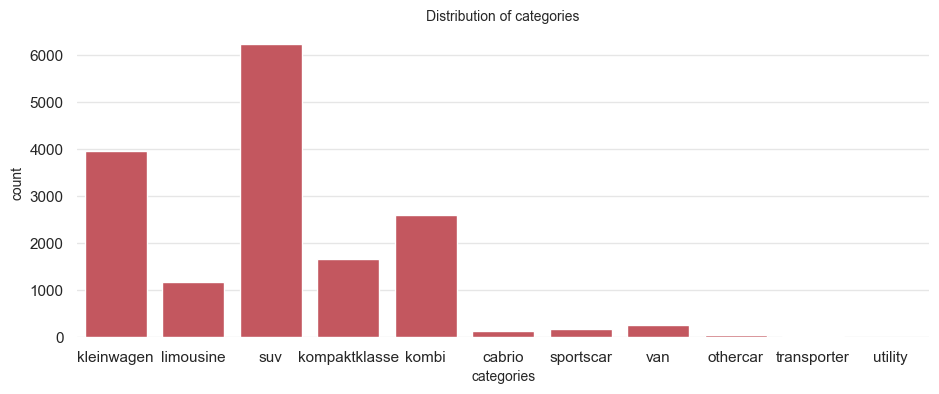

In [98]:
plt.figure(figsize=(11, 4))  # Setting the figure size
sns.countplot(data=df, x='categories', color=config.COLOR_PALETTE[4])  # Creating the count plot
plt.title("Distribution of categories")
plt.grid(axis='y')
plt.show()

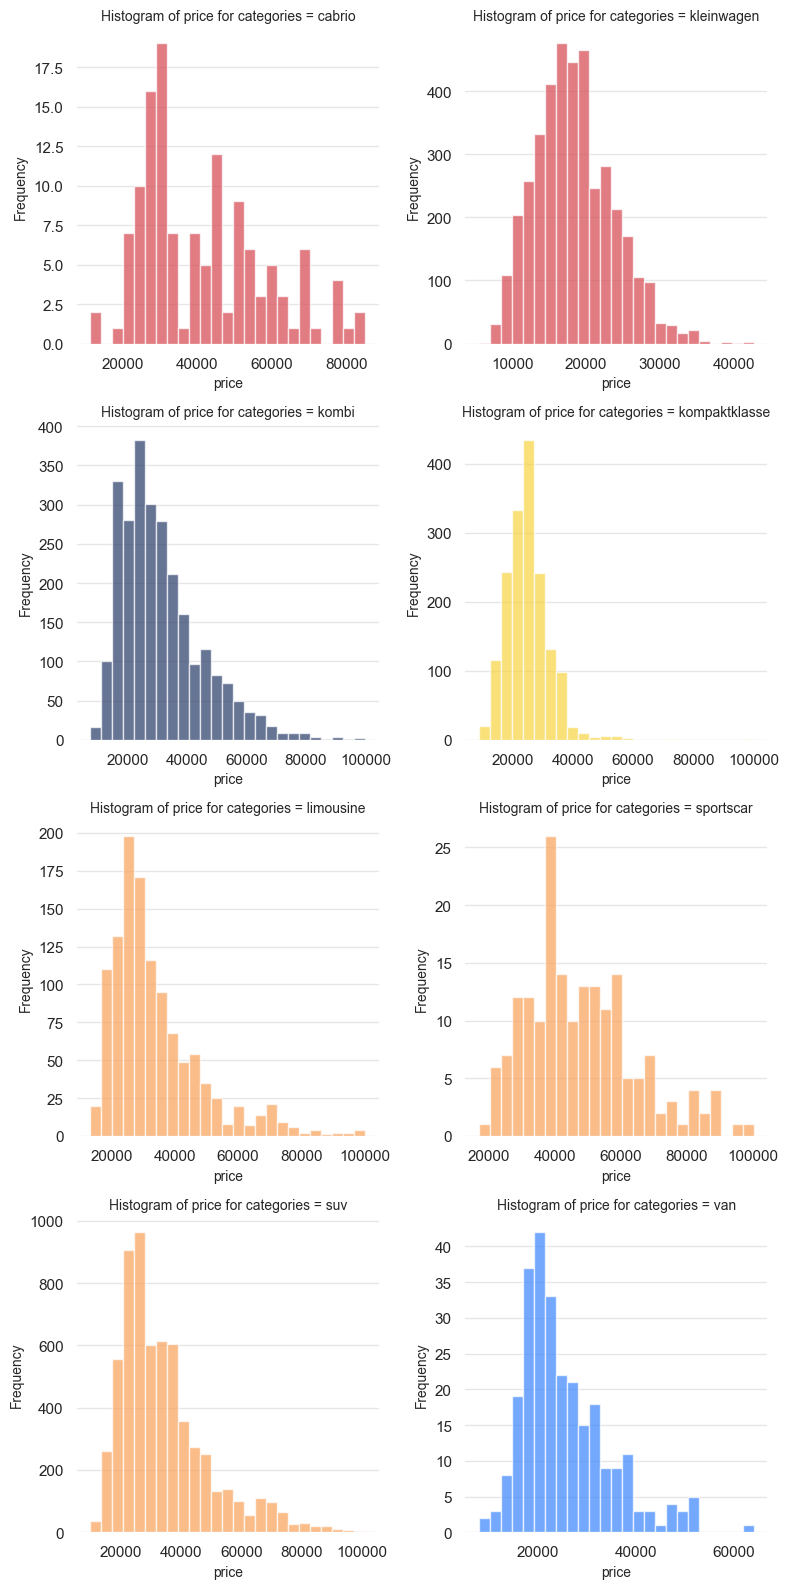

In [99]:
plot_grouped_histograms(df[df['categories'].isin(
    ['suv', 'limousine', 'van', 'kleinwagen', 'kombi', 'sportscar', 'kompaktklasse', 'cabrio'])], 'price', 'categories')

Among the analyzed features, the vehicle category emerges as the most informative. Through these graphical representations, we can distinctly discern whether a vehicle falls within the bracket of expensive or affordable. For instance, sports cars tend to maintain a rarity below the 20-thousand-euro mark, with a typical price hovering around 40 thousand euros. However, these can occasionally surge up to 100 thousand euros. Conversely, Kleinwagen class vehicles are notably the most economical, predominantly priced between 10 and 20 thousand euros, rarely stretching beyond 35 thousand euros.

Other vehicle types typically fall within the 20 to 30 thousand euro range. While limousines, convertibles, and SUVs have been observed to reach up to 80 thousand euros, the remaining models generally cap around 60 thousand euros. These insights provide a comprehensive view of the pricing trends across various vehicle categories.

In [100]:
# Calculate summary statistics
calculate_and_print_categorical_stats(df, 'categories')

Counts of categories in 'categories':
categories
suv              6237
kleinwagen       3961
kombi            2600
kompaktklasse    1667
limousine        1173
van               269
sportscar         184
cabrio            130
othercar           40
transporter        24
utility             7
Name: count, dtype: int64

Number of unique categories in 'categories': 11

Most frequent category in 'categories': suv (Count: 6237)


### Feature: interiorColor

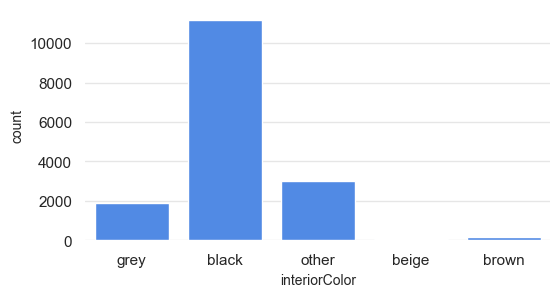

In [101]:
plt.figure(figsize=(6, 3))  # Setting the figure size
sns.countplot(data=df, x='interiorColor')  # Creating the count plot
plt.grid(axis='y')
plt.show()

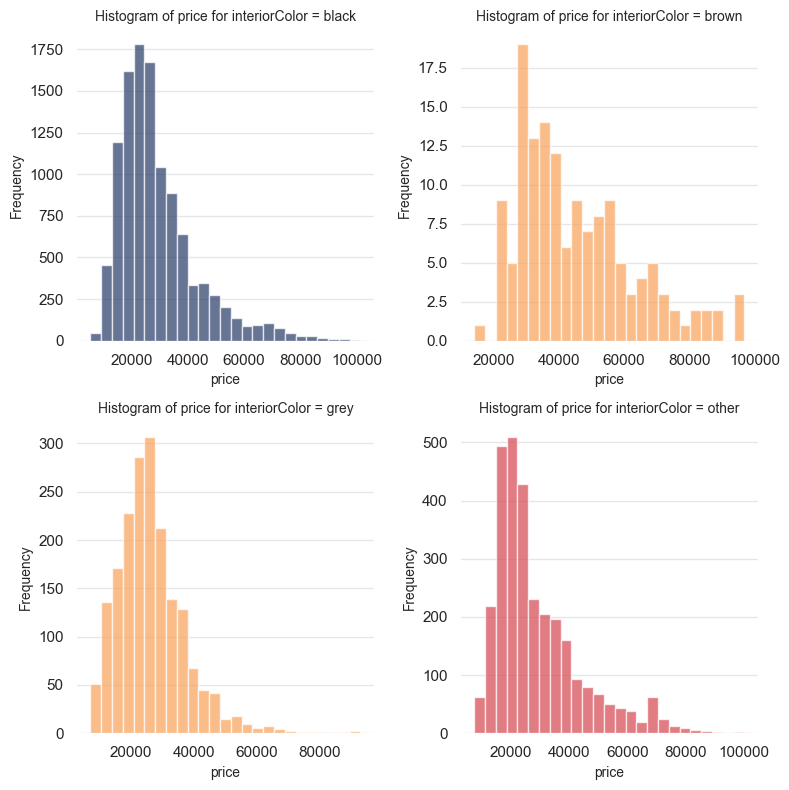

In [102]:
plot_grouped_histograms(df[df['interiorColor'].isin(['black', 'grey', 'other', 'brown'])], 'price', 'interiorColor')

Data shows that vehicle interior color really does not contribute to the price. Most vehicles have black interiors.

In [103]:
# Calculate summary statistics
calculate_and_print_categorical_stats(df, 'interiorColor')

Counts of categories in 'interiorColor':
interiorColor
black    11163
other     3021
grey      1881
brown      144
beige       83
Name: count, dtype: int64

Number of unique categories in 'interiorColor': 5

Most frequent category in 'interiorColor': black (Count: 11163)


### Feature: energyEfficiencyClass

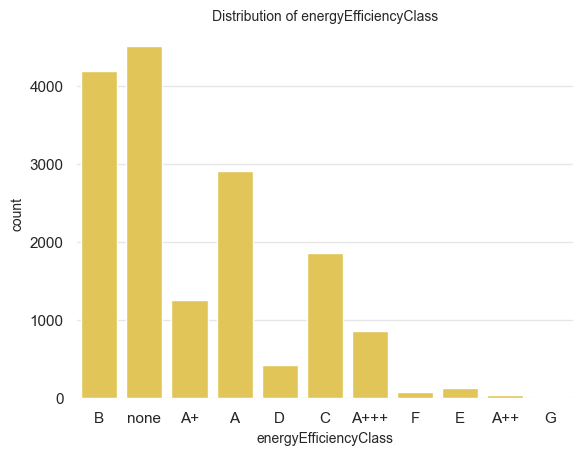

In [104]:
sns.countplot(data=df, x='energyEfficiencyClass', color=config.COLOR_PALETTE[3])  # Creating the count plot
plt.grid(axis='y')
plt.title("Distribution of energyEfficiencyClass")
plt.show()

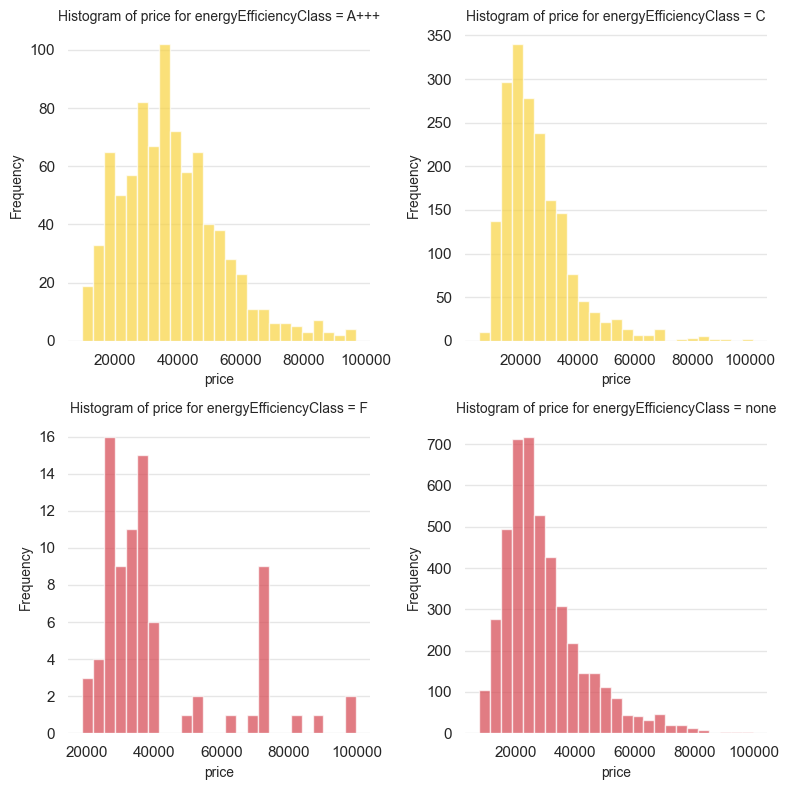

In [105]:
plot_grouped_histograms(df[df['energyEfficiencyClass'].isin(['A+++', 'C', 'F', 'none'])], 'price', 'energyEfficiencyClass')

The higher energy efficiency of the vehicle seems to correlate with its higher price. However, this relationship might be attributed to the tendency for newer vehicles to possess greater energy efficiency. Thus, it is plausible that this association reflects a correlation rather than a direct causation.

Conversely, a prevalent trend emerges with a majority of vehicles marked as 'none' followed by those in higher classes. This trend potentially suggests that vehicles exhibiting lower efficiency tend to be categorized as 'none'


In [106]:
# Calculate summary statistics
calculate_and_print_categorical_stats(df, 'energyEfficiencyClass')

Counts of categories in 'energyEfficiencyClass':
energyEfficiencyClass
none    4511
B       4188
A       2913
C       1866
A+      1262
A+++     857
D        423
E        134
F         82
A++       45
G         11
Name: count, dtype: int64

Number of unique categories in 'energyEfficiencyClass': 11

Most frequent category in 'energyEfficiencyClass': none (Count: 4511)


### Feature: undamaged

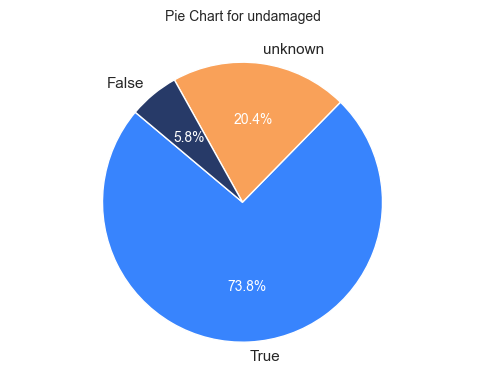

In [107]:
plot_pie_chart(df, 'undamaged')

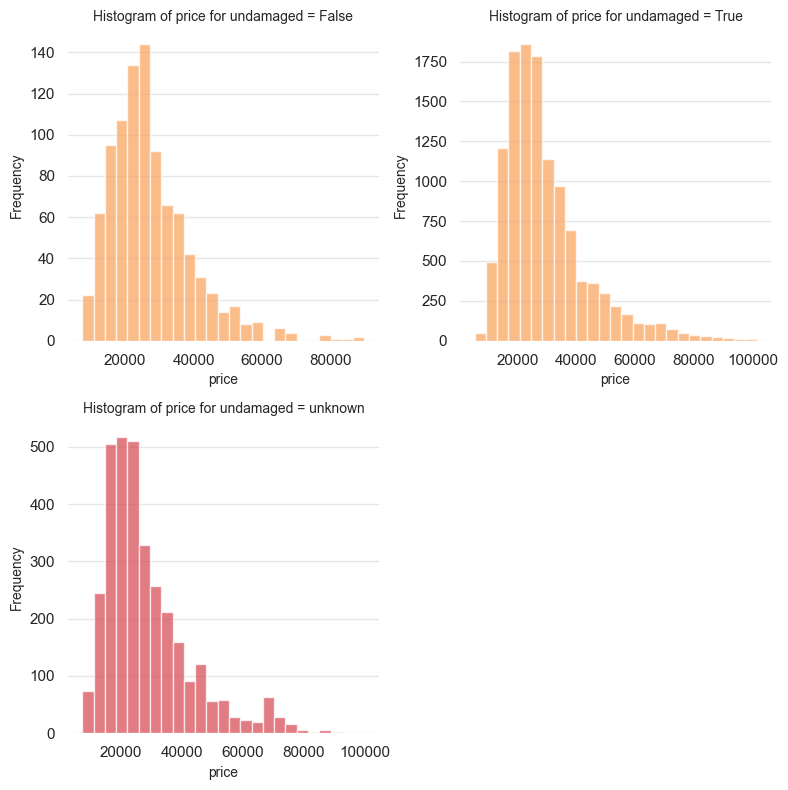

In [108]:
plot_grouped_histograms(df, 'price', 'undamaged')

Opting to designate the null undamaged vehicles as 'unknown' instead of eliminating them from our dataset has proven to be a judicious choice. This decision was bolstered by the observed pricing patterns, where the absence of data for undamaged vehicles remarkably aligns with the pricing trends of damaged ones. Such congruence strongly suggests a likelihood that the owners of damaged vehicles omitted these details in their listings.

Delving deeper into the broader data distribution, it becomes apparent that the most substantial contingent within the dataset comprises undamaged vehicles. This prominence underscores the significance of retaining and appropriately categorizing the 'unknown' subset, ensuring a more comprehensive and representative analysis of the entire vehicle inventory.

In [109]:
# Calculate summary statistics
calculate_and_print_categorical_stats(df, 'undamaged')

Counts of categories in 'undamaged':
undamaged
True       12020
unknown     3327
False        945
Name: count, dtype: int64

Number of unique categories in 'undamaged': 3

Most frequent category in 'undamaged': True (Count: 12020)


## Correlation Analysis

Correlation refers to a statistical measure that quantifies the strength and direction of the relationship between two quantitative variables. It assesses how changes in one variable are associated with changes in another variable. Correlation analysis is important for several reasons:

### 1. Understanding Relationships:
Correlation analysis helps us understand the relationship between two quantitative variables. It measures the strength and direction of the linear association between variables. This understanding is crucial in many fields to comprehend how changes in one variable might affect another.

### 2. Identifying Patterns and Trends:
By analyzing correlations, we can identify patterns and trends in the data. This helps in recognizing which variables tend to move together or in opposite directions. Understanding these patterns can provide insights into the behavior of the variables under consideration.

### 3. Prediction and Forecasting:
Correlation analysis assists in predictive modeling. Variables that are highly correlated may have predictive power. For example, if two variables are strongly positively correlated, changes in one variable might indicate potential changes in the other. This predictive ability is valuable in various fields such as finance, economics, and weather forecasting.

### 4. Feature Selection in Modeling:
In machine learning and statistical modeling, identifying correlated features is important for feature selection. Highly correlated features can lead to issues like multicollinearity, affecting the performance of models like regression. By understanding correlations, we can select the most relevant and uncorrelated features for modith ea5h other.

### 6. Checking Assumptions in Analysis:
In statistical analyses and experiments, correlation analysis helps in checking assumptions. For instance, linear regression assumes certain relationships between variables. Correlation analysis can confirm whether these assumptions about the relatiorther investigation.

In essence, correlation analysis is crucial because it provides insights into relationships among variables, aids in predictive modeling, supports decision-making, helps in understanding trends, and assists in research across various fields. It allows us to make informed decisions and draw meaningful conclusions from data.

In [110]:
# Calculate the correlation matrix for numeric values
correlation_matrix = df.select_dtypes(include=['number']).corr()

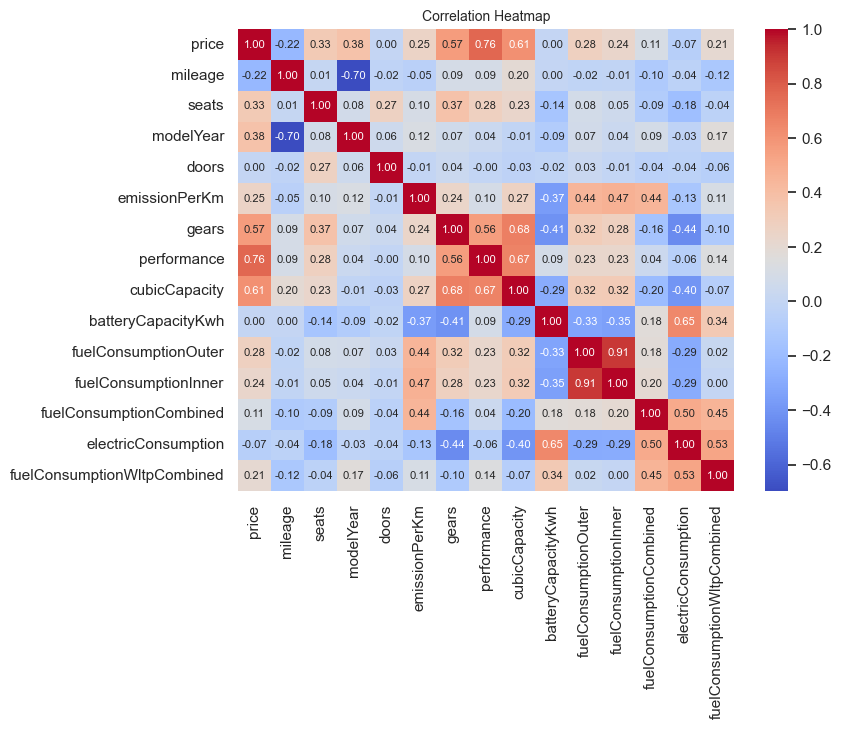

In [111]:
# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})
plt.title('Correlation Heatmap')
plt.show()

The insights gained from analyzing features can be cross-checked using this correlation matrix. However, our comparisons have primarily focused on variables in relation to price. It's important to note that correlations aren't exclusive to comparisons between variables and price alone; correlations can exist between other non-price variables as well. In essence, while our primary emphasis has been on understanding how different features relate to price, it's crucial to recognize that non-price variables might also exhibit connections among themselves. These inter-variable relationships beyond price could be just as significant and revealing.

The correlation matrix uncovers connections among various features, especially concerning price. However, correlation doesn't signify causation. While we see correlations between non-price variables, it doesn't mean one causes the change in another. Unaccounted-for factors, known as third variables, can influence observed correlations. Relying solely on correlation for causal claims can be misleading; it's crucial to consider other contributing factors.

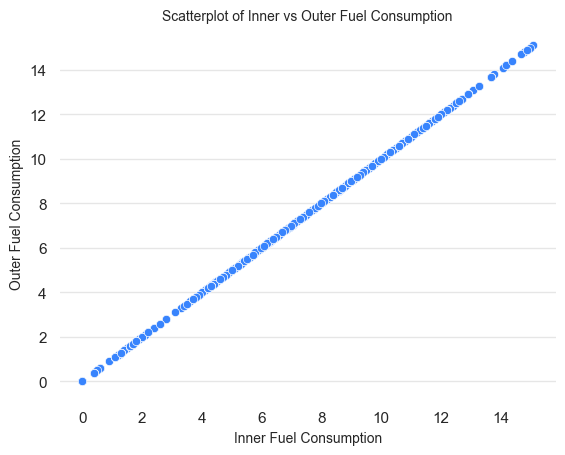

In [112]:
# Scatter plot for 'fuelConsumptionInner' and 'fuelConsumptionInner'
sns.scatterplot(data=df, x='fuelConsumptionInner', y='fuelConsumptionInner')
plt.grid(axis='y')  # Add gridlines along the y-axis for better visualization
plt.title('Scatterplot of Inner vs Outer Fuel Consumption')
plt.xlabel('Inner Fuel Consumption')  # Label for x-axis
plt.ylabel('Outer Fuel Consumption')  # Label for y-axis
plt.show()

We observe a distinct pattern in the distribution of data points between `fuelConsumptionInner` and `fuelConsumptionInner` – the relationship appears linear.

This apparent linear relationship between these variables could stem from several factors. One potential explanation might be that `fuelConsumptionInner` and `fuelConsumptionInner` are inherently related due to their nature or how they're measured. For example, in certain scenarios, these variables might have a direct cause-and-effect relationship, leading to their linear distribution.

However, it's important to note that correlation doesn't automatically imply causation. Other underlying factors might contribute to this observed relationship. These could include external variables not currently considered in our analysis, or it could be a result of shared characteristics or dependencies between these two variables.

In model building, when confronted with highly correlated variables such as these, it becomes crucial to make an informed choice. Selecting both variables in a predictive model might introduce multicollinearity issues, affecting model performance. Therefore, it's prudent to choose the variable that contributes better to the model's predictive power or select the one that carries more meaningful information, discarding the other to ensure model simplicity and accuracy.

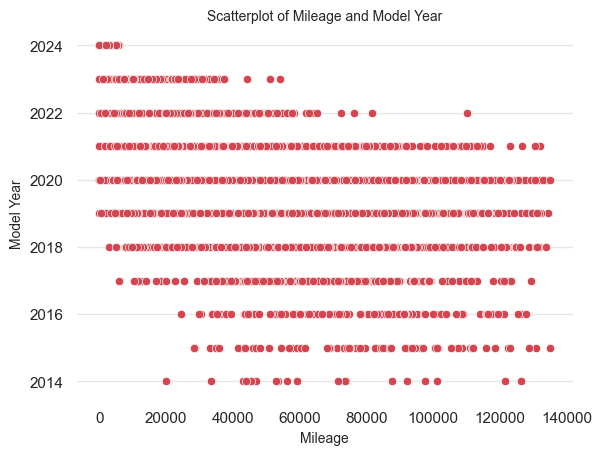

In [113]:
# Scatter plot for 'mileage' and 'modelYear'
sns.scatterplot(data=df, x='mileage', y='modelYear', color=config.COLOR_PALETTE[4])
plt.grid(axis='y')  # Add gridlines along the y-axis for better visualization
plt.title('Scatterplot of Mileage and Model Year')
plt.xlabel('Mileage')  # Label for x-axis
plt.ylabel('Model Year')  # Label for y-axis
plt.show()

Upon examination, although the presence of a strong linear correlation, as previously observed, is not apparent, an observable negative relationship emerges between Mileage and Model Year. While not strictly linear, there seems to be a trend indicating that as the Model Year increases, the Mileage tends to decrease. This observed negative relationship suggests that older vehicles, typically represented by earlier Model Years, tend to have higher Mileage compared to newer vehicles.

## Feature Engineering

Feature engineering holds paramount importance in machine learning as it directly impacts model performance and the ability to extract meaningful insights from data. Well-crafted features not only enhance model accuracy but also simplify complex data relationships, handle missing values, mitigate overfitting, and aid in creating more interpretable models. By refining or creating features that capture relevant information, feature engineering significantly influences the efficacy and robustness of machine learning models, making it a critical step in the data preprocessing pipeline.

### New Feature: horsepower

To convert performance in kilowatts (kW) to horsepower, you can use the conversion factor:

1 kilowatt (kW) is approximately equal to 1.341 mechanical or hydraulic horsepower (hp).

So, to calculate horsepower from performance given in kilowatts, you can use the formula:

Horsepower (hp) = Performance in kilowatts (kW) * 1.341

For instance, if the performance is specified as 50 kW:

Horsepower = 50 kW * 1.341 ≈ 67.05 horsepower

This conversion enables you to translate the performance of a vehicle or any machinery specified in kilowatts into the equivalent horsepower measure.

In [114]:
# Conversion factor from kilowatts (kW) to horsepower (hp)
kW_to_hp_conversion = 1.34102209

# Create a new column 'horsepower' by converting from kW to hp
df['horsepower'] = df['performance'] * kW_to_hp_conversion

# Convert the 'horsepower' column to float64 data type
df['horsepower'] = df['horsepower'].astype('float64')

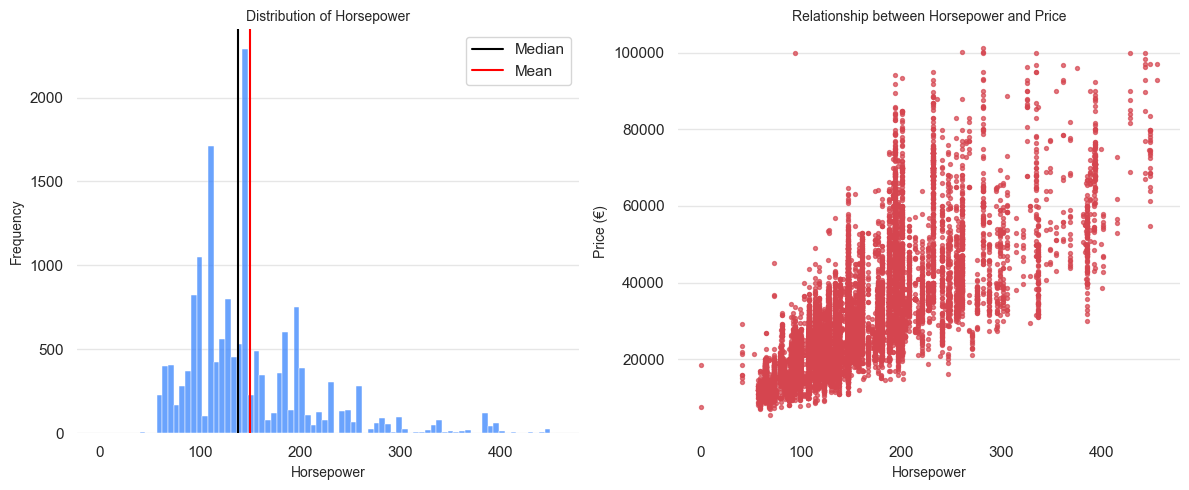

In [115]:
plot_distribution_and_scatter(df, 'horsepower')

In [116]:
# Calculate the correlation coefficient between 'horsepower' and 'price'
correlation_hp_price = df['horsepower'].corr(df['price'])

# Display the correlation coefficient
correlation_hp_price

0.7639462227599165

In [117]:
# Calculate skewness
skewness_horsepower = calculate_skewness(df, 'horsepower')
print(f"Skewness of 'horsepower' column: {skewness_horsepower}")

Skewness of 'horsepower' column: 1.5570843922379387


In [118]:
config.ASYMMETRIC_FEATURES.append('horsepower')

### New Feature: ageVehicle

To determine the age of a vehicle, you can calculate it by subtracting the model year of the vehicle from the current year. This method provides a straightforward way to ascertain how many years have elapsed since the manufacturing year of the vehicle.

For instance, if the current year is 2023 and the model year of the vehicle is 2018, the calculation for the age of the vehicle would be:

Age of Vehicle = Current Year - Model Year
Age of Vehicle = 2023 - 2018 = 5 years

By subtracting the model year from the current year, the resulting value represents the age of the vehicle in years. This calculation helps in understanding the longevity and aging of the vehicle, which can be relevant for various purposes such as resale value assessment, insurance considerations, and general maintenance planning.


In [119]:
# Calculate the age of the vehicle and create a new 'ageVehicle' column
df['ageVehicle'] = config.YEAR - df['modelYear']

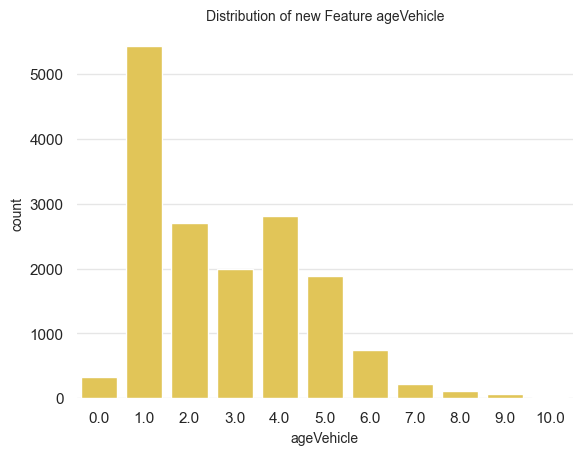

In [120]:
sns.countplot(data=df, x='ageVehicle', color=config.COLOR_PALETTE[3])  # Creating the count plot
plt.grid(axis='y')
plt.title("Distribution of new Feature ageVehicle")
plt.show()

In [121]:
# Calculate the correlation coefficient between 'ageVehicle' and 'price'
correlation_av_price = df['ageVehicle'].corr(df['price'])

# Display the correlation coefficient
correlation_av_price

-0.37595511641781876

### New Feature: isElectric

The new feature, named `isElectric`, signifies whether a vehicle operates as an electric car. It contains binary values, where '1' indicates the vehicle is electric, while '0' denotes a non-electric vehicle. This feature enables easy identification and differentiation between electric and non-electric cars within the dataset.

In [122]:
# Creating a new binary feature 'isElectric' based on the 'fuelType' column
df['isElectric'] = df['fuelType'].apply(lambda x: 1 if x.lower() == 'electric' else 0)

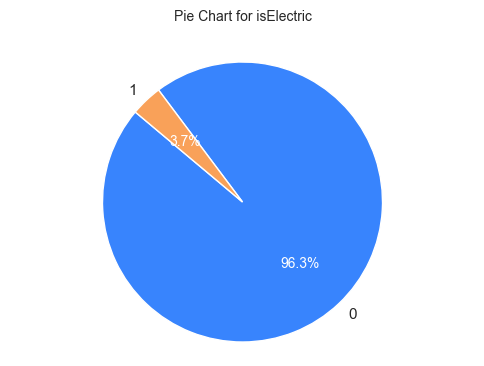

In [123]:
plot_pie_chart(df, 'isElectric')

# Probability Analysis and Hypotheses

## Events
    Sample space: Vehicles that are using either petrol(gasoline) or diesel fuel
    1. A vehicle having manual transmission
    2. A vehichle having low combined fuel consumption

## Nr. of Vehicles that are using either petrol(gasoline) or diesel fuel

In [124]:
# Nr. of vehicles using diesel fuel
vehicles_d = df[(df["fuelType"] == "diesel")]
nr_of_vehicles_d = len(vehicles_d)
print("Nr. of vehicles using diesel fuel:", nr_of_vehicles_d)
 
# Nr. of vehicles using petrol(gasoline) fuel
vehicles_p = df[(df["fuelType"] == "petrol")]
nr_of_vehicles_p = len(vehicles_p)
print("Nr. of vehicles using petrol fuel:", nr_of_vehicles_p)

# Nr. of total vehicles(using either diesel or petrol fuel)
vehicles_d_or_p = df[(df["fuelType"] == "petrol") | (df["fuelType"] == "diesel")]
nr_of_total_vehicles = len(vehicles_d_or_p)
# nr_of_total_vehicles = nr_of_vehicles_d + nr_of_vehicles_p
print("Nr. of total vehicles(using either diesel or petrol fuel):", nr_of_total_vehicles)

Nr. of vehicles using diesel fuel: 2981
Nr. of vehicles using petrol fuel: 11021
Nr. of total vehicles(using either diesel or petrol fuel): 14002


## Nr. of vehicles having manual transmission in the sample space

In [125]:
# Nr. of vehicles having manual transmission in the sample space
vehicles_manual = vehicles_d_or_p[vehicles_d_or_p["gearBox"] == "manual_gear"]
nr_of_vehicles_manual = len(vehicles_manual)
print("Nr. of vehicles having manual transmission in the sample space:", nr_of_vehicles_manual)

Nr. of vehicles having manual transmission in the sample space: 6633


## Nr. of vehicles having automatic transmission in the sample space

In [126]:
# Nr. of vehicles having automatic transmission in the sample space
vehicles_automatic = vehicles_d_or_p[vehicles_d_or_p["gearBox"] == "automatic_gear"]
nr_of_vehicles_automatic = len(vehicles_automatic)
print("Nr. of vehicles having automatic transmission in the sample space:", nr_of_vehicles_automatic)

Nr. of vehicles having automatic transmission in the sample space: 7357


## Nr. of vehicles having a low* value of combined fuel consumption in the sample space
*: low fuel consumption combined: ∀x, x <= 5.34L/100km

In [127]:
# Nr. of vehicles having low fuel consumption combined
vehicles_low_fcc = vehicles_d_or_p[vehicles_d_or_p["fuelConsumptionCombined"] <= 5.34]
nr_of_vehicles_low_fcc = len(vehicles_low_fcc)
print("Nr. of vehicles having low fuel consumption combined:", nr_of_vehicles_low_fcc)

Nr. of vehicles having low fuel consumption combined: 7270


## Probabilities of the events

1. Probability of a vehicle having manual transmission

In [128]:
# Probability of a vehicle having manual transmission
p_manual = nr_of_vehicles_manual/nr_of_total_vehicles
print("Probability of a vehicle having manual transmission:", round(p_manual, 3))

Probability of a vehicle having manual transmission: 0.474


2. Probability of a vehicle having a low value of combined fuel consumption 

In [129]:
# Probability of a vehicle having a low value of combined fuel consumption
p_low_fcc = nr_of_vehicles_low_fcc/nr_of_total_vehicles
print("Probability of a vehicle having a low value of combined fuel consumption:", round(p_low_fcc, 3))

Probability of a vehicle having a low value of combined fuel consumption: 0.519


## Conditional Probabilities of the events

### 1. The probability of a manual transmission vehicle having low fuel consumption
    P(low | manual) = P(low ∩ manual)/P(manual)

In [130]:
#Nr. of vehicles with manual transmission and low consumption
manual_and_low = vehicles_d_or_p[(vehicles_d_or_p["gearBox"] == "manual_gear") & (vehicles_d_or_p["fuelConsumptionCombined"] <= 5.34)]
nr_of_manual_and_low = len(manual_and_low)
# print(nr_of_manual_and_low)
p_manual_and_low = nr_of_manual_and_low/nr_of_total_vehicles
# print(p_manual_and_low)

In [131]:
# The probability of a manual transmission vehicle having low fuel consumption
p_low_when_manual = p_manual_and_low/p_manual
print("Probability of a manual transmission vehicle having low fuel consumption:", round(p_low_when_manual, 2))

Probability of a manual transmission vehicle having low fuel consumption: 0.65


### 2. The probability of a vehichle with low fuel consumption having a manual transmission
    P(manual | low) = P(manual ∩ low)/P(low)

In [132]:
# The probability of a vehichle with low fuel consumption having a manual transmission
p_manual_when_low = p_manual_and_low/p_low_fcc
print("Probability of a vehichle with low fuel consumption having a manual transmission:", round(p_manual_when_low, 2))

Probability of a vehichle with low fuel consumption having a manual transmission: 0.59


## Hypothesis Tests
    1. Transmission type does not affect fuel consumption
    2. Fuel type does not affect fuel consumption
    3. Fuel type does not affect the vehicle's CO2 emissions
    4. Vehicle age does not affect the vehicle's CO2 emissions

### 1. Transmission type does not affect fuel consumption
    H0: Fuel consumption of automatic transmission vehicles and manual transmission vehicles is the same.
    H1: Fuel consumption of automatic transmission vehicles and manual transmission vehicles is not the same.

In [133]:
# fuel consumption data of manual transmission vehicles
data_vehicles_manual = vehicles_manual["fuelConsumptionCombined"]
mean_manual = np.mean(data_vehicles_manual)

# data of automatic transmission vehicles
data_vehicles_automatic = vehicles_automatic["fuelConsumptionCombined"]
mean_automatic = np.mean(data_vehicles_automatic)

print("Mean of manual transmission vehicles' fuel consumption:", round(mean_manual, 3))
print("Mean of automatic transmission vehicles' fuel consumption:", round(mean_automatic,3))

# t-test
t_statistic_transmission, p_value_transmission = ttest_ind(data_vehicles_manual, data_vehicles_automatic)

print("T-statistic:", t_statistic_transmission)
print("p value:", p_value_transmission)

# p value check
if p_value_transmission < 0.05:
    print("H0 hypothesis was rejected. There is a significant difference between the two groups.")
else:
    print("H0 hypothesis was accepted. There was no significant difference between the two groups.")

Mean of manual transmission vehicles' fuel consumption: 5.008
Mean of automatic transmission vehicles' fuel consumption: 5.631
T-statistic: -30.32378131696662
p value: 1.1183451221195806e-195
H0 hypothesis was rejected. There is a significant difference between the two groups.


Conclusion: The argument that transmission type affects fuel consumption can be inferred from the results.

### 2. Fuel type does not affect fuel consumption
    H0: Fuel consumption of diesel vehicles and gasoline vehicles is the same.
    H1: Fuel consumption of diesel vehicles and gasoline vehicles is not the same.

In [134]:
# fuel consumption data of diesel vehicles
fuel_data_vehicles_d = vehicles_d["fuelConsumptionCombined"]
mean_d_consumption = np.mean(fuel_data_vehicles_d)

# fuel consumption data of gasoline(petrol) vehicles
fuel_data_vehicles_p = vehicles_p["fuelConsumptionCombined"]
mean_p_consumption = np.mean(fuel_data_vehicles_p)

print("Mean of diesel vehicles' fuel consumption:", round(mean_d_consumption, 3))
print("Mean of gasoline vehicles' fuel consumption:", round(mean_p_consumption,3))

# t-test
t_statistic_fuel, p_value_fuel = ttest_ind(fuel_data_vehicles_d, fuel_data_vehicles_p)

print("T-statistic:", t_statistic_fuel)
print("p value:", p_value_fuel)

# p value check
if p_value_fuel < 0.05:
    print("H0 hypothesis was rejected. There is a significant difference between the two groups.")
else:
    print("H0 hypothesis was accepted. There was no significant difference between the two groups.")

Mean of diesel vehicles' fuel consumption: 5.098
Mean of gasoline vehicles' fuel consumption: 5.4
T-statistic: -11.742485140711192
p value: 1.086769249381472e-31
H0 hypothesis was rejected. There is a significant difference between the two groups.


Conclusion: We can say that the fuel consumption is affected by the fuel type.

### 3. Fuel type does not affect the vehicle's CO2 emissions
    H0: CO2 emission values of diesel vehicles and gasoline vehicles are the same.
    H1: CO2 emission values of diesel vehicles and gasoline vehicles are not the same.

In [135]:
# emission data of diesel vehicles
CO2_data_vehicles_d = vehicles_d["emissionPerKm"]
mean_d_emission = np.mean(CO2_data_vehicles_d)

# emission data of gasoline(petrol) vehicles
CO2_data_vehicles_p = vehicles_p["emissionPerKm"]
mean_p_emission = np.mean(CO2_data_vehicles_p)

print("Mean of diesel vehicles' emission:", round(mean_d_emission, 3))
print("Mean of gasoline vehicles' emission:", round(mean_p_emission,3))

# t-test
t_statistic_emission, p_value_emission = ttest_ind(CO2_data_vehicles_d, CO2_data_vehicles_p)

print("T-statistic:", t_statistic_emission)
print("p value:", p_value_emission)

# p value check
if p_value_emission < 0.05:
    print("H0 hypothesis was rejected. There is a significant difference between the two groups.")
else:
    print("H0 hypothesis was accepted. There was no significant difference between the two groups.")

Mean of diesel vehicles' emission: 134.454
Mean of gasoline vehicles' emission: 126.169
T-statistic: 17.591172717860438
p value: 1.5695991504691523e-68
H0 hypothesis was rejected. There is a significant difference between the two groups.


Conclusion: The results shows that the emission values are affected by the fuel type.

### 4. Vehicle age does not affect the vehicle's CO2 emissions
    H0: There is no difference in CO2 emissions between older and younger vehicles.
    H1: There is a notable difference in CO2 emissions between older and younger vehicles.

In [136]:
# emission data of old vehicles
vehicles_old = df[df["ageVehicle"] > 5]
CO2_data_vehicles_old = vehicles_old["emissionPerKm"]
mean_old_emission = np.mean(CO2_data_vehicles_old)

# emission data of young vehicles
vehicles_young = df[df["ageVehicle"] <= 5]
CO2_data_vehicles_young = vehicles_young["emissionPerKm"]
mean_young_emission = np.mean(CO2_data_vehicles_young)

print("Mean of old vehicles' emission:", round(mean_old_emission,3))
print("Mean of young vehicles' emissions:", round(mean_young_emission, 3))

# t-test
t_statistic_emission_age, p_value_emission_age = ttest_ind(CO2_data_vehicles_old, CO2_data_vehicles_young)

print("T-statistic:", t_statistic_emission_age)
print("p value:", p_value_emission_age)

# p value check
if p_value_emission < 0.01:
    print("H0 hypothesis was rejected. There is a significant difference between the two groups.")
else:
    print("H0 hypothesis was accepted. There was no significant difference between the two groups.")

Mean of old vehicles' emission: 122.878
Mean of young vehicles' emissions: 120.834
T-statistic: 2.095419268287644
p value: 0.036149135822957465
H0 hypothesis was rejected. There is a significant difference between the two groups.


Conclusion: We can say that there is a difference between the emissions of cars younger than 5 years old and cars older than 5 years old.

# Data Preprocessing

Data preprocessing is a crucial step in machine learning and data analysis pipelines. It involves cleaning, transforming, and organizing raw data into a more suitable format for analysis and model training. The quality of the data and how well it's preprocessed can significantly impact the performance of machine learning models.

### Steps in Data Preprocessing:

**Data Transformation:** Scaling numerical features, encoding categorical variables, and normalization to bring all features to a similar scale.

**Data Reduction:** Dimensionality reduction techniques like Principal Component Analysis (PCA) or feature selection to reduce the number of features while retaining important information.

**Splitting Data:** Dividing the dataset into training, validation, and testing sets to evaluate the model's performance accurately.

**Normalization and Standardization:** Scaling the numerical features to a common range (Normalization) or making their mean zero and standard deviation one (Standardization).

**Handling Categorical Data:** Converting categorical data into numerical format through techniques like one-hot encoding or label encoding.

### Importance of Data Preprocessing:

1. **Improved Model Performance:** Clean and preprocessed data leads to better model performance and more accurate predictions.

2. **Reduced Overfitting:** Proper preprocessing helps in reducing overfitting by removing noise and irrelevant information from the data.

3. **Enhanced Interpretability:** Well-preprocessed data results in better interpretability of models, enabling a clearer understanding of relationships between variables.

4. **Better Feature Representation:** Feature engineering and transformation create more meaningful features, capturing essential information from the dataset.

5. **Increased Efficiency:** Preprocessing optimizes the data for machine learning algorithms, making them converge faster and reducing computational resources.

6. **Real-world Applicability:** Preprocessing prepares data for deployment in real-world applications, ensuring it can handle unseen or future data effectively.

## Logarithmic transformation
Logarithmic transformation is a mathematical process used to alter the scale of data by applying the logarithm function to its values. This transformation helps in handling skewed data distributions, compressing large ranges, and making patterns more visible or relationships more linear for analysis. Logarithmic transformations are beneficial in various fields like statistics, economics, and signal processing, aiding in better data interpretation, normalization, and visualization. They convert multiplicative relationships into additive ones, making it easier to analyze data exhibiting exponential growth or wide-ranging values.

In [137]:
print("Logarithmic transformation will be applied to the following features.")

for feature in config.ASYMMETRIC_FEATURES:
    print(feature)

Logarithmic transformation will be applied to the following features.
mileage
performance
horsepower


In [138]:
# Logarithmic transformation function
def logarithmic_transform(x):
    return np.log10(x)

# Apply logarithmic transformation to selected columns
for column in config.ASYMMETRIC_FEATURES:
    if column in df.columns:
        df[column] = (df[column] + 0.1).apply(logarithmic_transform)

### Encoding and Standardization

**Encoding:** Encoding is the process of converting categorical data (non-numeric data or labels) into a numerical format that machine learning algorithms can understand. Commonly used encoding techniques include Label Encoding, One-Hot Encoding, and Ordinal Encoding. Label Encoding assigns a unique numeric label to each category, while One-Hot Encoding creates binary columns for each category, representing its presence or absence. Ordinal Encoding maps categories to ordered integers based on their rank or predefined order.

**Standardization:** Standardization is a data preprocessing technique used to rescale features to have a mean of zero and a standard deviation of one. It helps in bringing all features to a similar scale, preventing some features from dominating due to their larger values. Standardization involves subtracting the mean from each value and dividing by the standard deviation. This process is essential for algorithms sensitive to feature scaling, like those based on distances or gradients, such as K-Nearest Neighbors or Support Vector Machines. Standardization makes the data more amenable for modeling and improves the convergence of certain machine learning algorithms.

In [139]:
# Before this process, we need to reserve the price column as the target feature.
y = df['price']
X = df.drop('price', axis=1)

In [140]:
# Get rid of unnecessary features
X.drop(['url', 'batteryCapacityKwh'], axis=1, inplace=True)

In [141]:
# Convert boolean values to strings
X['undamaged'] = X['undamaged'].map({True: 'True', False: 'False', 'unknown': 'unknown'})

In [142]:
# Selecting numeric and non-numeric (categorical) features from the DataFrame X
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

In [143]:
# Numeric feature transformation pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical feature transformation pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, drop='if_binary'))
])

# Define the preprocessor to handle both numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough',  # Include any columns not transformed
    verbose_feature_names_out=False
)

In [144]:
# Fit and transform the data using the preprocessor
X_transformed = preprocessor.fit_transform(X)

# Create a DataFrame with transformed features and proper column names
X = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())

In [145]:
# Get the updated number of features after standard scaling and encoding
num_features_after_processing = X.shape[1]

# Print the updated number of features
print(f'Number of features after standard scaling and encoding: {num_features_after_processing}')

Number of features after standard scaling and encoding: 270


## Feature Importance and Selecting

Feature selection process is a crucial aspect of understanding machine learning models. Feature importance quantifies the relevance of different features in predicting the target variable. In various machine learning algorithms like Random Forest Regressor, feature importance scores are calculated to determine the contribution of each feature towards making accurate predictions.

Importance of Feature Importance Scores in Random Forest Regressor:

Feature Importance scores generated by the Random Forest Regressor provide valuable insights into which features have a more significant impact on the model's predictive performance. These scores help in identifying key predictors that influence the output and aid in feature selection by highlighting the most relevant attributes for making accurate predictions.

In [146]:
def feature_importance(X, y):
    """
    Calculate feature importance using RandomForestRegressor.

    Parameters:
    X (DataFrame): Input features.
    y (Series): Target variable.

    Returns:
    DataFrame: DataFrame containing feature names and their importance scores sorted in descending order.
    """
    # Initialize RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=100, random_state=config.SEED)

    # Fit RandomForestRegressor to your data
    rf.fit(X, y)

    # Get feature importances
    feature_importances = rf.feature_importances_

    # Create a DataFrame with feature names and their importance scores
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sort the features by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    return feature_importance_df


# Call the function and store the result
feature_importance_df = feature_importance(X, y)

# Print the top 50 features and their importance scores
top_50_features = feature_importance_df.head(50)
print("Top 50 Important Features:")
print(top_50_features)

Top 50 Important Features:
                         Feature  Importance
13                    horsepower    0.371838
6                    performance    0.248805
2                      modelYear    0.050996
14                    ageVehicle    0.050317
7                  cubicCapacity    0.047952
0                        mileage    0.037406
5                          gears    0.029704
4                  emissionPerKm    0.025742
12   fuelConsumptionWltpCombined    0.014349
217                   model_xc90    0.009643
8           fuelConsumptionOuter    0.008542
1                          seats    0.007737
9           fuelConsumptionInner    0.006925
117                model_glc-300    0.006861
10       fuelConsumptionCombined    0.006214
239              fuelType_petrol    0.005414
241        categories_kleinwagen    0.004958
19                  make_hyundai    0.004555
247               categories_suv    0.003515
210                     model_x5    0.003421
229          gearBox_manual_

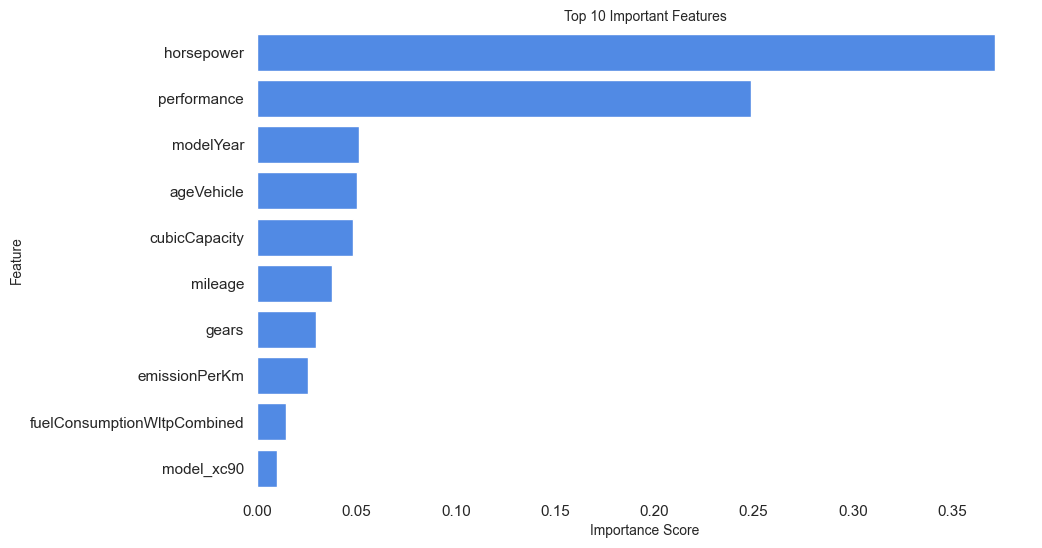

In [147]:
# Take the first 10 rows
top_10_features = top_50_features.head(10)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features, orient='h')
plt.title('Top 10 Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [148]:
# Drop columns with low importance
selected_features = feature_importance_df[feature_importance_df['Importance'] >= 0.0001]['Feature']
X_selected = X[selected_features]

In [149]:
# Let's drop the features with low importance from the features with high correlation.
X_selected.drop(['performance', 'modelYear'], axis=1, inplace=True)

Let's reassess the feature importance scores within the remaining features and observe how they've been updated. Then, perform dimension reduction by applying PCA to the remaining features.

In [150]:
# Call the function and store the result
feature_importance_df = feature_importance(X_selected, y)

# Print the top 50 features and their importance scores
top_50_features = feature_importance_df.head(50)
print("Top 50 Important Features:")
print(top_50_features)

Top 50 Important Features:
                        Feature  Importance
0                    horsepower    0.620273
1                    ageVehicle    0.101154
2                 cubicCapacity    0.048088
3                       mileage    0.037545
4                         gears    0.029892
5                 emissionPerKm    0.025945
6   fuelConsumptionWltpCombined    0.014674
7                    model_xc90    0.009683
8          fuelConsumptionOuter    0.008657
9                         seats    0.007676
10         fuelConsumptionInner    0.007249
11                model_glc-300    0.006872
12      fuelConsumptionCombined    0.006317
13              fuelType_petrol    0.005513
14        categories_kleinwagen    0.005056
15                 make_hyundai    0.004593
16               categories_suv    0.003573
17                     model_x5    0.003407
18          gearBox_manual_gear    0.003289
19           make_mercedes-benz    0.002553
20                    make_audi    0.002310
21   

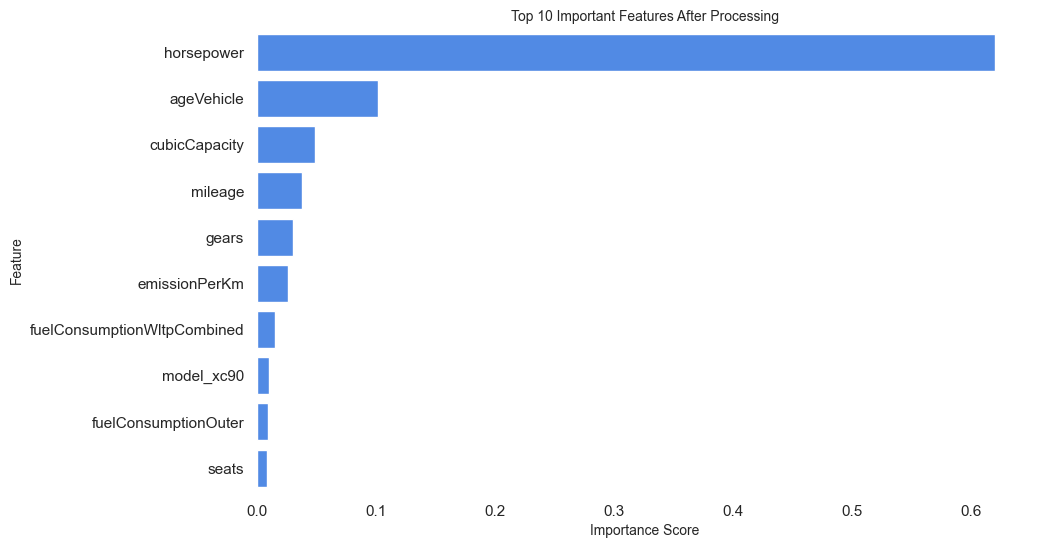

In [151]:
# Take the first 10 rows
top_10_features = top_50_features.head(10)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features, orient='h')
plt.title('Top 10 Important Features After Processing')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [152]:
# Extract the features after the first 25
features_after_25 = X_selected.iloc[:, 25:]

# Initialize PCA to reduce dimensionality
pca = PCA(n_components=10, random_state=config.SEED)

# Fit PCA to the features after the first 25
pca.fit(features_after_25)

# Transform the features to their principal components
features_pca = pca.transform(features_after_25)

# Convert the principal components back to a DataFrame
features_pca_df = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(features_pca.shape[1])])

# Concatenate the principal components with the original selected features
X_selected_with_pca = pd.concat([X_selected.iloc[:, :25], features_pca_df], axis=1)

## Separation of data into training and test set

In [153]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_with_pca, y, train_size=0.88, random_state=config.SEED)

# Display the number of observations in the training and testing datasets
print(f"Number of observations in training set: {len(X_train)}")
print(f"Number of observations in testing set: {len(X_test)}")

Number of observations in training set: 14336
Number of observations in testing set: 1956


# Machine Learning

In our data science project, our primary objective revolves around predicting car prices based on various car features. The fundamental problem we aim to solve is to develop a robust and accurate machine learning model that can effectively estimate the price of a car given its attributes, such as mileage, brand, engine specifications, and more.

To address this prediction task, we experimented with several machine learning models, including Random Forest, Neural Network, and Decision Tree algorithms. These models were chosen due to their capabilities in handling regression problems and their diverse approaches in capturing complex relationships within the data.

Our choice of evaluation metrics aimed to capture the predictive performance of these models accurately. We utilized metrics like Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R2) to assess the models' performance. MSE measures the average squared differences between predicted and actual values, MAE represents the average absolute differences, while R2 quantifies the proportion of variance in the target variable explained by the model.

1. **Mean Squared Error (MSE)**:
   - **Relevance to the Problem**: MSE calculates the average squared differences between predicted and actual values. In the context of car price prediction, MSE penalizes larger errors more heavily due to squaring, making it sensitive to outliers. This is particularly relevant because in pricing, larger errors might significantly impact the perceived value or competitiveness of a car listing.
   - **Interpretability**: Squaring the errors highlights larger discrepancies, allowing us to understand and prioritize areas where the model might be performing poorly.

2. **Mean Absolute Error (MAE)**:
   - **Robustness to Outliers**: MAE measures the average absolute differences between predicted and actual values. Unlike MSE, MAE is less sensitive to outliers as it doesn’t square the errors. In car price prediction, outliers might exist due to unique or rare car attributes, and MAE provides a robust assessment by considering these differences equally.
   - **Ease of Interpretation**: MAE provides a straightforward interpretation, representing the average absolute deviation between predicted and actual prices, making it easily understandable for stakeholders.

3. **R-squared (R2)**:
   - **Variance Explanation**: R2 quantifies the proportion of variance in the target variable explained by the model. For car price prediction, it's crucial to understand how much of the variability in prices our model can capture. Higher R2 values indicate that the model effectively captures variance, showcasing its ability to explain and predict prices accurately.
   - **Comparison of Model Performance**: R2 allows us to compare our model's performance against a baseline, such as a simple mean model. It indicates whether our model is performing better than a basic average or constant model.

Among the models tested, the Random Forest algorithm demonstrated promising results and was selected to advance further in our analysis. Random Forests showed resilience against overfitting tendencies commonly observed in Decision Trees while providing superior predictive power compared to the simpler models. Its ability to handle high-dimensional data and reduce variance through ensemble learning made it an ideal candidate for further refinement and optimization.

To optimize the selected Random Forest model, we utilized Optuna Optimization, an efficient method for hyperparameter tuning. This process involved iteratively exploring the hyperparameter space to discover the configuration that maximizes the model's performance metrics. By leveraging Optuna Optimization, we aimed to strike a balance between model complexity, generalization ability, and predictive accuracy, ensuring the best possible outcomes for our car price prediction task.

Through our experimentation, evaluation, and refinement process, we aim to deliver a robust and reliable machine learning model capable of accurately predicting car prices, thereby providing valuable insights and aiding decision-making processes within the automotive domain.

## Evaluation and Selection of Models
### RandomForestRegressor

In [154]:
# Initialize RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=config.SEED)

In [155]:
# Train the RandomForestRegressor model
rf_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_regressor.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Evaluation metrics for RandomForestRegressor:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Evaluation metrics for RandomForestRegressor:
Mean Squared Error (MSE): 11637238.627090096
Mean Absolute Error (MAE): 2192.351791471188
R-squared (R2): 0.9381642701353965


### DecisionTreeRegressor

In [156]:
# Create a DecisionTreeRegressor model
dt_regressor = DecisionTreeRegressor(random_state=config.SEED)

In [157]:
# Train the DecisionTreeRegressor model
dt_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_regressor.predict(X_test)

# Calculate evaluation metrics for DecisionTreeRegressor
mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

# Print the evaluation metrics for DecisionTreeRegressor
print("Evaluation metrics for DecisionTreeRegressor:")
print(f"Mean Squared Error (MSE): {mse_dt}")
print(f"Mean Absolute Error (MAE): {mae_dt}")
print(f"R-squared (R2): {r2_dt}")

Evaluation metrics for DecisionTreeRegressor:
Mean Squared Error (MSE): 27659564.739068545
Mean Absolute Error (MAE): 3001.4327145247394
R-squared (R2): 0.8530279022210591


### LinearRegression

In [158]:
# Create a LinearRegression model
linear_regressor = LinearRegression()

In [159]:
# Train the LinearRegression model
linear_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = linear_regressor.predict(X_test)

# Calculate evaluation metrics for LinearRegression
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Print the evaluation metrics for LinearRegression
print("Evaluation metrics for LinearRegression:")
print(f"Mean Squared Error (MSE): {mse_linear}")
print(f"Mean Absolute Error (MAE): {mae_linear}")
print(f"R-squared (R2): {r2_linear}")

Evaluation metrics for LinearRegression:
Mean Squared Error (MSE): 31342813.23399943
Mean Absolute Error (MAE): 3921.2433428285253
R-squared (R2): 0.8334565617806762


### Neural Network

In [160]:
input_shape = X_train.shape[1]
print(f"Input shape is {input_shape}")

Input shape is 35


In [161]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [162]:
def to_tensor(data):
    """
    Converts input data to a PyTorch tensor.

    Parameters:
    - data: Input data (pandas DataFrame or numpy array)

    Returns:
    - torch.Tensor: Converted data as a PyTorch tensor of type torch.float and moved to the specified device.
    """
    return torch.from_numpy(data.to_numpy()).type(torch.float).to(device)

In [163]:
X_train_tensor = to_tensor(X_train)
X_test_tensor = to_tensor(X_test)
y_train_tensor = to_tensor(y_train).unsqueeze(dim=1)
y_test_tensor = to_tensor(y_test).unsqueeze(dim=1)

In [164]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        # Define the neural network layers
        self.il = nn.Linear(input_shape, 64)  # Input layer
        self.l1 = nn.ReLU()  # Activation function
        self.dense1 = nn.Linear(64, 64)  # Hidden layer 1
        self.l2 = nn.ReLU()  # Activation function
        self.dense2 = nn.Linear(64, 32)  # Hidden layer 2
        self.l3 = nn.ReLU()  # Activation function
        self.dense3 = nn.Linear(32, 32)  # Hidden layer 3
        self.l4 = nn.ReLU()  # Activation function
        self.dense4 = nn.Linear(32, 16)  # Hidden layer 4
        self.l5 = nn.ReLU()  # Activation function
        self.dense5 = nn.Linear(16, 1)  # Hidden layer 5
        self.ol = nn.Linear(1, 1)  # Output layer

    def forward(self, x):
        # Forward pass through the network
        x = self.il(x)
        x = self.l1(x)
        x = self.dense1(x)
        x = self.l2(x)
        x = self.dense2(x)
        x = self.l3(x)
        x = self.dense3(x)
        x = self.l4(x)
        x = self.dense4(x)
        x = self.l5(x)
        x = self.dense5(x)
        output = self.ol(x)

        return output

    def fit(self, x_train, y_train,
            optimizer, loss_fn,
            x_valid=None, y_valid=None,
            epochs=100, verbose=True,
            scheduler=None,
            clip_gradient=None):
        # Training loop
        self.history = {
            "train_loss": [],
            "validation_loss": []
        }
        
        for epoch in range(epochs):
            # Train the model
            self.train()
            y_pred = self(x_train)
            loss = loss_fn(y_pred, y_train).squeeze()
            optimizer.zero_grad()
            loss.backward()
    
            # Gradient clipping
            if clip_gradient is not None:
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=clip_gradient)
    
            optimizer.step()
    
            # Learning rate scheduler step
            if scheduler is not None:
                scheduler.step()
    
            # Evaluate the model on validation data
            if (x_valid is not None) and (y_valid is not None):
                self.eval()
                with torch.no_grad():
                    y_pred = self(x_valid)
                    validation_loss = loss_fn(y_pred, y_valid)
    
                self.history["train_loss"].append(loss.item())
                self.history["validation_loss"].append(validation_loss.item())
    
                if verbose and epoch % 100 == 0:
                    print(f"Epoch: {epoch} | Training Loss: {loss.item()} | Validation Loss: {validation_loss.item()}")
            else:
                # If no validation data provided, only print training loss
                print(f"Epoch: {epoch} | Training Loss: {loss.item()}")
                self.history["train_loss"].append(loss.item())
    
        self.history['train_loss'] = np.array(self.history['train_loss'])
        self.history['validation_loss'] = np.array(self.history['validation_loss'])

    def predict(self, input_values):
        # Prediction function
        with torch.inference_mode():
            predictions = self(input_values)

        return predictions

In [165]:
# Initialize a neural network model with the given input shape
nn_model = NeuralNetwork(input_shape)

# Move the model to the specified device for computation
nn_model.to(device)

NeuralNetwork(
  (il): Linear(in_features=35, out_features=64, bias=True)
  (l1): ReLU()
  (dense1): Linear(in_features=64, out_features=64, bias=True)
  (l2): ReLU()
  (dense2): Linear(in_features=64, out_features=32, bias=True)
  (l3): ReLU()
  (dense3): Linear(in_features=32, out_features=32, bias=True)
  (l4): ReLU()
  (dense4): Linear(in_features=32, out_features=16, bias=True)
  (l5): ReLU()
  (dense5): Linear(in_features=16, out_features=1, bias=True)
  (ol): Linear(in_features=1, out_features=1, bias=True)
)

In [166]:
# Define the loss function
loss_function = nn.MSELoss()

# Initialize the optimizer with the model parameters and learning rate
learning_rate = 0.1
optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)

# Define a scheduler to adjust the learning rate during training
step_size = 40
gamma = 0.95
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Train the model using the fit method with specified parameters
epochs = 2000
nn_model.fit(X_train_tensor, y_train_tensor, optimizer, loss_function, 
          x_valid=X_test_tensor, y_valid=y_test_tensor, 
          epochs=epochs, verbose=True, scheduler=scheduler)

Epoch: 0 | Training Loss: 1043183360.0 | Validation Loss: 1000290240.0
Epoch: 100 | Training Loss: 23264302.0 | Validation Loss: 22265872.0
Epoch: 200 | Training Loss: 19879210.0 | Validation Loss: 19327390.0
Epoch: 300 | Training Loss: 17375476.0 | Validation Loss: 17161708.0
Epoch: 400 | Training Loss: 16181577.0 | Validation Loss: 16451637.0
Epoch: 500 | Training Loss: 15439418.0 | Validation Loss: 15936043.0
Epoch: 600 | Training Loss: 14839278.0 | Validation Loss: 15535014.0
Epoch: 700 | Training Loss: 14221915.0 | Validation Loss: 15295658.0
Epoch: 800 | Training Loss: 13600641.0 | Validation Loss: 15101206.0
Epoch: 900 | Training Loss: 13045772.0 | Validation Loss: 14891820.0
Epoch: 1000 | Training Loss: 12539871.0 | Validation Loss: 14573392.0
Epoch: 1100 | Training Loss: 12085601.0 | Validation Loss: 14497593.0
Epoch: 1200 | Training Loss: 12114101.0 | Validation Loss: 14529659.0
Epoch: 1300 | Training Loss: 11428877.0 | Validation Loss: 14481653.0
Epoch: 1400 | Training Loss:

In [167]:
y_pred = nn_model.predict(X_test_tensor).cpu()

In [168]:
# Convert predictions to numpy array
y_test_np = y_test.values

# Calculate evaluation metrics
mse = mean_squared_error(y_test_np, y_pred)
mae = mean_absolute_error(y_test_np, y_pred)
r2 = r2_score(y_test_np, y_pred)

# Print the evaluation metrics
print("Evaluation metrics for Neural Network:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Evaluation metrics for Neural Network:
Mean Squared Error (MSE): 14325410.370585945
Mean Absolute Error (MAE): 2520.4731010951878
R-squared (R2): 0.9238803779607085


### Evaluation

| Model                  | MSE            | MAE            | R-squared     |
|------------------------|----------------|----------------|---------------|
| RandomForestRegressor  | 11637238.63    | 2192.35        | 0.93816       |
| DecisionTreeRegressor  | 27659564.74    | 3001.43        | 0.85303       |
| LinearRegression       | 31342813.23    | 3921.24        | 0.83346       |
| Neural Network         | 14325410.37    | 2520.47        | 0.92388       |

#### Random Forest Regressor:
- **MSE:** 11637238.63
- **MAE:** 2192.35
- **R-squared:** 0.93816

The Random Forest Regressor demonstrates the lowest MSE and MAE among the models, indicating better accuracy in predicting the target variable. Its R-squared value is high (0.93816), suggesting that a significant proportion of the variance in the target variable is captured by the model.

#### Decision Tree Regressor:
- **MSE:** 27659564.74
- **MAE:** 3001.43
- **R-squared:** 0.85303

The Decision Tree Regressor has higher MSE and MAE compared to the Random Forest Regressor, indicating less accuracy. The R-squared value is lower (0.85303), suggesting that this model explains less variance in the target variable compared to the Random Forest.

#### Linear Regression:
- **MSE:** 31342813.23
- **MAE:** 3921.24
- **R-squared:** 0.83346

Linear Regression demonstrates higher MSE and MAE compared to both Random Forest and Decision Tree models. Its R-squared value is also lower (0.83346), indicating that this model explains less variance in the target variable compared to the other models.

#### Neural Network:
- **MSE:** 14325410.37
- **MAE:** 2520.47
- **R-squared:** 0.92388

The Neural Network has a moderately lower MSE and MAE than the Decision Tree and Linear Regression models but higher than the Random Forest. Its R-squared value (0.92388) is good but slightly lower than the Random Forest, suggesting a slightly lesser fit for the data.

### Selection and Justification:

The Random Forest Regressor still appears to perform the best among the evaluated models, with the lowest MSE and MAE and the highest R-squared value. It continues to demonstrate better accuracy in predicting the target variable and explains a higher proportion of the variance compared to the other models.

Regarding overfitting and underfitting:
- **Random Forest Regressor:** While performing well based on the evaluation metrics, careful hyperparameter tuning and regularization techniques should be applied to mitigate potential overfitting.
- **Decision Tree Regressor:** This model could potentially suffer from overfitting due to its tendency to create complex trees that perfectly fit the training data.
- **Linear Regression:** It might still be suffering from underfitting, not capturing the complexity of the data adequately.
- **Neural Network:** While showing promising performance, its slightly lower R-squared compared to the Random Forest might indicate a slight overfitting or a less optimal fit to the data.

Therefore, the Random Forest Regressor remains selected for further fine-tuning due to its superior performance in this evaluation, but caution should be exercised to optimize hyperparameters and prevent overfitting.


## Fine Tuning RandomForestRegressor

In [169]:
# Define objective function for optimization
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Initialize RandomForestRegressor with suggested hyperparameters
    rf_regressor = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=config.SEED
    )

    # Fit the RandomForestRegressor
    rf_regressor.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = rf_regressor.predict(X_test)

    # Calculate mean squared error as the metric to minimize
    return mean_squared_error(y_test, y_pred)

# Split data into train and test sets

# Perform the hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
best_rf = RandomForestRegressor(**best_params, random_state=config.SEED)
best_rf.fit(X_train, y_train)

# Make predictions on the test set using the best model
y_pred = best_rf.predict(X_test)

# Calculate evaluation metrics with the best model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Evaluation metrics for RandomForestRegressor with optimized hyperparameters:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

[I 2024-01-03 21:03:02,228] A new study created in memory with name: no-name-b31ac0af-f555-4cc2-bc2f-39a45ec3b915
[I 2024-01-03 21:04:08,732] Trial 0 finished with value: 11946535.06947661 and parameters: {'n_estimators': 219, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 0 with value: 11946535.06947661.
[I 2024-01-03 21:04:36,774] Trial 1 finished with value: 31282119.165174466 and parameters: {'n_estimators': 263, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 11946535.06947661.
[I 2024-01-03 21:04:57,605] Trial 2 finished with value: 13171719.773239514 and parameters: {'n_estimators': 83, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 11946535.06947661.
[I 2024-01-03 21:06:08,384] Trial 3 finished with value: 19934059.440462172 and parameters: {'n_estimators': 458, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 11946

Evaluation metrics for RandomForestRegressor with optimized hyperparameters:
Mean Squared Error (MSE): 11718802.225050874
Mean Absolute Error (MAE): 2210.067633876541
R-squared (R2): 0.9377308731095293


In [170]:
# Save the model to a file using pickle
with open('best_rf_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

## Conclusion

The success of our base model can be primarily attributed to the very well-done data cleaning and pre-processing stages. The meticulous handling of data, including handling missing values, encoding categorical variables, and scaling features, ensured that the model received high-quality input, enabling it to perform well right from the outset.

Despite our efforts to optimize the success metrics of the best model selected among the three models using Optuna, a widely utilized and successful optimization framework, there was no observable improvement in the final outcome. The likely reason for this outcome could be attributed to the nature of pricing data for cars, often influenced by individuals who might not necessarily be experts in the field. This scenario implies that there isn't a singular definitive price that accurately represents a car's value.

Consequently, our model might not be capable of achieving a significantly improved state considering the inherent variability in car prices. It's plausible that the significant discrepancies between the predicted prices from our model and the actual listed prices for certain vehicles might stem from sellers aiming to sell their vehicles at higher or lower values than anticipated.

Overall, it's noteworthy that approximately 94% of the provided prices closely align with our model's predictions, indicating a relatively accurate estimation for the majority of cases. The estimated prices in the remaining part are likely to reflect reality.


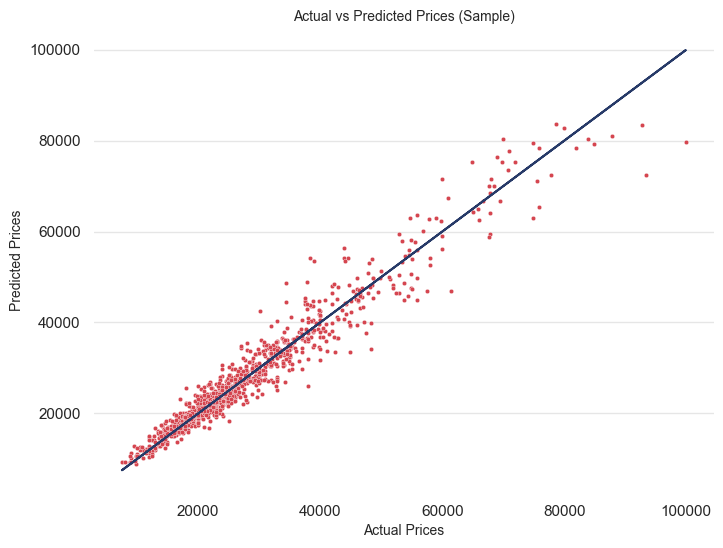

In [171]:
# Make predictions on the test set using the best model
y_pred = best_rf.predict(X_test)

# Create a DataFrame to store actual and predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Select a random sample of 100 data points for visualization
sample_results = results.sample(n=1000, random_state=config.SEED)  # Change n to display a different number of points

# Display a scatter plot of actual vs predicted values for the selected sample
plt.figure(figsize=(8, 6))

# Scatter plot for Actual values
sns.scatterplot(x='Actual', y='Predicted', data=sample_results, alpha=1, color=config.COLOR_PALETTE[4], s=10)

# Plot diagonal line for perfect prediction (actual = predicted)
plt.plot(sample_results['Actual'], sample_results['Actual'], color=config.COLOR_PALETTE[2])

plt.title('Actual vs Predicted Prices (Sample)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(axis='y')
plt.show()